In [6]:
import os
import sqlite3
import json
import time
import logging
import gc
import math
import random
import base64
from io import BytesIO
from collections import defaultdict
from typing import Dict, List, Tuple, Optional
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from transformers import AutoTokenizer, AutoModelForMaskedLM, Trainer, TrainingArguments, EvalPrediction
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
from huggingface_hub import login
import detoxify

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
BASE_DIR = "/content/V1"
os.makedirs(BASE_DIR, exist_ok=True)
file_handler = logging.FileHandler(os.path.join(BASE_DIR, "recommender.log"))
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(logging.Formatter("%(asctime)s - %(levelname)s - %(message)s"))
logger = logging.getLogger(__name__)
logger.addHandler(file_handler)

# Configuration class
class Config:
    HF_TOKEN = "hf_xxxxxxxxxxxxxxxxxxxxxxxx"
    DATA_PATH = "/content/pd.csv"
    MODEL_NAME = "nlpie/tiny-biobert"
    MODEL_DIR = os.path.join(BASE_DIR, "fine_tuned_model")
    EMBEDDINGS_PATH = os.path.join(BASE_DIR, "case_embeddings.npy")
    DB_PATH = os.path.join(BASE_DIR, "user_profiles.db")
    MAX_LENGTH = 64
    NUM_EPOCHS = 2
    TRAIN_BATCH_SIZE = 2
    LEARNING_RATE = 2e-5
    TOP_K = 5
    BATCH_SIZE = 8
    SIMILARITY_THRESHOLD = 0.7
    LR_STEP_SIZE = 1
    LR_GAMMA = 0.1
    TOXICITY_MODEL = None
    EMBEDDING_DIM = None

    @staticmethod
    def init_toxicity_model():
        try:
            Config.TOXICITY_MODEL = detoxify.Detoxify('original')
            logger.info("Detoxify model loaded successfully.")
        except Exception as e:
            logger.error(f"Failed to load Detoxify model: {e}. Skipping toxicity checks.")
            with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
                f.write(f"Failed to load Detoxify model: {e}. Skipping toxicity checks.\n")

# Initialize environment
def init_environment():
    os.makedirs(os.path.join(BASE_DIR, "hf_cache"), exist_ok=True)
    os.makedirs(os.path.join(BASE_DIR, "nltk_data"), exist_ok=True)
    os.environ["TRANSFORMERS_CACHE"] = os.path.join(BASE_DIR, "hf_cache")
    try:
        nltk.download('wordnet', download_dir=os.path.join(BASE_DIR, "nltk_data"), quiet=True)
        logger.info("NLTK wordnet downloaded successfully.")
    except Exception as e:
        logger.error(f"Failed to download NLTK wordnet: {e}. Skipping toxicity checks.")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Failed to download NLTK wordnet: {e}. Skipping toxicity checks.\n")

# Initialize user profile database
def init_database():
    with sqlite3.connect(Config.DB_PATH) as conn:
        cursor = conn.cursor()
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS users (
                user_id TEXT PRIMARY KEY,
                name TEXT UNIQUE,
                gender TEXT,
                city TEXT,
                past_symptoms TEXT,
                ratings TEXT
            )
        """)
        users = [
            ("1", "Iqra", "Female", "Kabirwala", "[]", "{}"),
            ("2", "Moafi", "Female", "Lahore", "[]", "{}"),
            ("3", "Sumair", "Male", "Quetta", "[]", "{}")
        ]
        cursor.executemany("INSERT OR IGNORE INTO users VALUES (?, ?, ?, ?, ?, ?)", users)
        conn.commit()
    logger.info("Initialized user profile database.")
    with open(os.path.join(BASE_DIR, "output_log.txt"), "a") as f:
        f.write("Initialized user profile database.\n")

# Load and preprocess data
def load_and_preprocess_data() -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    try:
        df = pd.read_csv(Config.DATA_PATH)
        if df.empty:
            raise ValueError("Dataset is empty.")
        logger.info(f"Loaded dataset with {len(df)} rows.")
    except FileNotFoundError as e:
        logger.error(f"File {Config.DATA_PATH} not found: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"File {Config.DATA_PATH} not found: {e}\n")
        raise

    required_columns = [
        "CommonAgeGroup", "Sex", "Severity", "Specialist", "Name", "Address/Details",
        "City", "Rating", "Mapped_Category", "Processed_Symptoms", "Processed_Disease",
        "Processed_Treatment"
    ]
    if not all(col in df.columns for col in required_columns):
        raiseFuenteValueError("Missing required columns in pd.csv.")

    df = df.dropna(subset=["Processed_Symptoms", "Processed_Disease", "Processed_Treatment"])
    df = df.sample(frac=0.8, random_state=42)
    df["Rating"] = df["Rating"].astype(float)
    df.to_pickle(os.path.join(BASE_DIR, "processed_data.pkl"))

    interaction_matrix = df.pivot_table(index="Processed_Symptoms", columns="Name", values="Rating", fill_value=0)
    doctor_similarity = cosine_similarity(interaction_matrix.T)
    doctor_similarity_df = pd.DataFrame(
        doctor_similarity, index=interaction_matrix.columns, columns=interaction_matrix.columns
    )
    logger.info("Processed dataset and created doctor similarity matrix.")
    return df, doctor_similarity_df, interaction_matrix

# Load model and tokenizer
def load_tokenizer_and_model() -> Tuple[AutoTokenizer, AutoModelForMaskedLM, torch.device]:
    login(token=Config.HF_TOKEN)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"Using device: {device}")

    tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_NAME, trust_remote_code=True)
    try:
        model = AutoModelForMaskedLM.from_pretrained(
            Config.MODEL_NAME,
            trust_remote_code=True,
            use_safetensors=False
        )
        model = prepare_model_for_kbit_training(model)
        lora_config = LoraConfig(
            r=8,
            lora_alpha=32,
            target_modules=["query", "value"],
            lora_dropout=0.05,
            bias="none",
            # Change task_type from "MASKED" to a valid type for feature extraction
            task_type="FEATURE_EXTRACTION"
        )
        model = get_peft_model(model, lora_config)
        model.to(device)
        sample_input = tokenizer("test", return_tensors="pt").to(device)
        with torch.no_grad():
            Config.EMBEDDING_DIM = model(**sample_input, output_hidden_states=True).hidden_states[-1].shape[-1]
        logger.info(f"Loaded {Config.MODEL_NAME} with LoRA on {device}, EMBEDDING_DIM={Config.EMBEDDING_DIM}")
    except Exception as e:
        logger.error(f"Model loading failed: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Model loading failed: {e}\n")
        raise
    return tokenizer, model, device

# Custom dataset for fine-tuning
class MedicalDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer: AutoTokenizer, max_length: int):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        row = self.df.iloc[idx]
        input_text = (
            f"Symptoms: {row['Processed_Symptoms']}. Age: {row['CommonAgeGroup']}. "
            f"Sex: {row['Sex']}. Severity: {row['Severity']}."
        )
        target_text = (
            f"Condition: {row['Processed_Disease']}. Doctor: {row['Name']}. "
            f"Treatment: {row['Processed_Treatment']}. Specialist: {row['Specialist']}."
        )
        inputs = self.tokenizer(
            input_text, max_length=self.max_length, padding="max_length",
            truncation=True, return_tensors="pt"
        )
        targets = self.tokenizer(
            target_text, max_length=self.max_length, padding="max_length",
            truncation=True, return_tensors="pt"
        )
        labels = targets["input_ids"].clone()
        labels[labels == self.tokenizer.pad_token_id] = -100
        return {
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "labels": labels.squeeze()
        }

# Custom Trainer for evaluation
class CustomEvalPrediction(EvalPrediction):
    def __init__(self, predictions: torch.Tensor, label_ids: torch.Tensor, metrics: Dict, num_samples: int):
        super().__init__(predictions=predictions, label_ids=label_ids)
        self.metrics = metrics
        self.num_samples = num_samples

class CustomTrainer(Trainer):
    def evaluation_loop(self, dataloader, description: str, prediction_loss_only: Optional[bool] = None,
                        ignore_keys: Optional[List[str]] = None, metric_key_prefix: str = "eval") -> CustomEvalPrediction:
        self.model.eval()
        total_eval_loss = 0.0
        # Initialize total_samples to 0 before the loop
        total_samples = 0
        all_preds = []
        all_labels = []

        for step, inputs in enumerate(dataloader):
            inputs = self._prepare_inputs(inputs)
            with torch.no_grad():
                outputs = self.model(**inputs)
                loss = outputs.loss
                logits = outputs.logits
                total_eval_loss += loss.item() * inputs["input_ids"].size(0)
                # Corrected variable name and accumulation
                total_samples += inputs["input_ids"].size(0)
                all_preds.append(logits.cpu())
                all_labels.append(inputs["labels"].cpu())

            if (step + 1) % self.args.eval_accumulation_steps == 0:
                gc.collect()
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

        all_preds = torch.cat(all_preds, dim=0)
        all_labels = torch.cat(all_labels, dim=0)

        metrics = self.compute_metrics(EvalPrediction(predictions=all_preds, label_ids=all_labels)) if self.compute_metrics else {}
        metrics[f"{metric_key_prefix}_loss"] = total_eval_loss / total_samples

        return CustomEvalPrediction(
            predictions=all_preds,
            label_ids=all_labels,
            metrics=metrics,
            num_samples=total_samples
        )

    def compute_metrics(self, eval_pred: EvalPrediction) -> Dict[str, float]:
        predictions, label_ids = eval_pred.predictions, eval_pred.label_ids
        predictions = predictions.argmax(-1).flatten()
        label_ids = label_ids.flatten()
        valid_indices = label_ids != -100
        predictions = predictions[valid_indices]
        label_ids = label_ids[valid_indices]
        return {
            "accuracy": float(np.mean([p == l for p, l in zip(predictions, label_ids)])) if len(predictions) > 0 else 0.0,
            "precision": float(precision_score(label_ids, predictions, average="weighted", zero_division=0)) if len(predictions) > 0 else 0.0,
            "recall": float(recall_score(label_ids, predictions, average="weighted", zero_division=0)) if len(predictions) > 0 else 0.0,
            "f1": float(f1_score(label_ids, predictions, average="weighted", zero_division=0)) if len(predictions) > 0 else 0.0
        }

# Fine-tune model
def fine_tune_model(model: AutoModelForMaskedLM, tokenizer: AutoTokenizer, df: pd.DataFrame,
                    learning_rate: float, device: torch.device) -> CustomTrainer:
    logger.info("Starting training from scratch.")
    train_size = int(0.8 * len(df))
    train_df = df[:train_size]
    val_df = df[train_size:].sample(n=min(500, len(df[train_size:])), random_state=42)
    train_dataset = MedicalDataset(train_df, tokenizer, Config.MAX_LENGTH)
    val_dataset = MedicalDataset(val_df, tokenizer, Config.MAX_LENGTH)

    training_args = TrainingArguments(
        output_dir=os.path.join(BASE_DIR, "results"),
        per_device_train_batch_size=Config.TRAIN_BATCH_SIZE,
        per_device_eval_batch_size=1,
        num_train_epochs=Config.NUM_EPOCHS,
        learning_rate=learning_rate,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_steps=8,
        save_total_limit=1,
        report_to="none",
        gradient_accumulation_steps=2,
        eval_accumulation_steps=2
    )

    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=lambda eval_pred: {
            "accuracy": float(np.mean([p == l for p, l in zip(eval_pred.predictions.argmax(-1).flatten(), eval_pred.label_ids.flatten())])) if eval_pred.predictions.numel() > 0 else 0.0,
            "precision": float(precision_score(
                eval_pred.label_ids.flatten(), eval_pred.predictions.argmax(-1).flatten(), average="weighted", zero_division=0
            )) if eval_pred.predictions.numel() > 0 else 0.0,
            "recall": float(recall_score(
                eval_pred.label_ids.flatten(), eval_pred.predictions.argmax(-1).flatten(), average="weighted", zero_division=0
            )) if eval_pred.predictions.numel() > 0 else 0.0,
            "f1": float(f1_score(
                eval_pred.label_ids.flatten(), eval_pred.predictions.argmax(-1).flatten(), average="weighted", zero_division=0
            )) if eval_pred.predictions.numel() > 0 else 0.0
        }
    )

    try:
        trainer.train()
        logger.info("Training completed successfully.")
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    except Exception as e:
        logger.error(f"Error during training: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Error during training: {e}\n")
        raise

    eval_results = trainer.evaluate()
    with open(os.path.join(BASE_DIR, "train_eval_results.json"), "w") as f:
        json.dump(eval_results, f, indent=2)
    model.save_pretrained(Config.MODEL_DIR, safe_serialization=True)
    tokenizer.save_pretrained(Config.MODEL_DIR)
    logger.info("Fine-tuned model and tokenizer saved.")
    return trainer

# Extract semantic features
def extract_semantic_features(text: str, model: AutoModelForMaskedLM, tokenizer: AutoTokenizer,
                             device: torch.device) -> np.ndarray:
    inputs = tokenizer(
        text, return_tensors="pt", max_length=Config.MAX_LENGTH,
        truncation=True, padding=True
    ).to(device)
    try:
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            features = torch.mean(outputs.hidden_states[-1], dim=1).to(torch.float32)
            logger.info(f"Extracted features with shape: {features.shape}")
        return features.cpu().numpy().flatten()
    except Exception as e:
        logger.error(f"Error extracting semantic features: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Error extracting semantic features: {e}\n")
        return np.zeros(Config.EMBEDDING_DIM)

# Generate embeddings
def generate_case_embeddings(df: pd.DataFrame, model: AutoModelForMaskedLM, tokenizer: AutoTokenizer,
                            device: torch.device) -> np.ndarray:
    model.eval()
    embeddings = []
    max_rows = min(5000, len(df))
    df = df.iloc[:max_rows]

    for i in range(0, len(df), Config.BATCH_SIZE):
        batch_df = df[i:i + Config.BATCH_SIZE]
        batch_embeddings = []
        for _, row in batch_df.iterrows():
            input_text = (
                f"Symptoms: {row['Processed_Symptoms']}. Age: {row['CommonAgeGroup']}. "
                f"Sex: {row['Sex']}. Severity: {row['Severity']}."
            )
            try:
                embedding = extract_semantic_features(input_text, model, tokenizer, device)
                batch_embeddings.append(embedding)
            except Exception as e:
                logger.error(f"Error during embedding generation: {e}")
                with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
                    f.write(f"Error during embedding generation: {e}\n")
                batch_embeddings.append(np.zeros(Config.EMBEDDING_DIM))
        embeddings.extend(batch_embeddings)
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        logger.info(f"Processed batch {i // Config.BATCH_SIZE + 1}/{len(df) // Config.BATCH_SIZE + 1}")

    embeddings = np.array(embeddings, dtype=np.float32)
    np.save(Config.EMBEDDINGS_PATH, embeddings)
    logger.info(f"Generated embeddings with shape: {embeddings.shape}")
    return embeddings

# Compute metrics
def compute_metrics(recommendations: Dict, df: pd.DataFrame, case_embeddings: np.ndarray,
                    model: AutoModelForMaskedLM, tokenizer: AutoTokenizer, device: torch.device,
                    top_k: int = Config.TOP_K) -> Tuple[Dict, List, List, List]:
    y_true = []
    y_pred = []
    y_scores = []
    latencies = []
    toxicities = []
    ranks = []
    recommended_items = set()
    total_items = len(df["Processed_Disease"].unique())
    item_popularity = df["Processed_Disease"].value_counts().to_dict()
    similarities = []
    personalization_scores = []
    robustness_scores = []
    ctr_simulations = []

    with sqlite3.connect(Config.DB_PATH) as conn:
        cursor = conn.cursor()
        for name, rec in recommendations.items():
            symptoms = rec["symptoms"]
            predicted_conditions = [cond["Condition"] for cond in rec["likely_conditions"]]
            scores = [cond["Score"] for cond in rec["likely_conditions"]]
            actual_conditions = df[df["Processed_Symptoms"].str.lower() == symptoms.lower()]["Processed_Disease"].values
            actual_condition = actual_conditions[0] if len(actual_conditions) > 0 else "Unknown"

            y_true.append(actual_condition)
            y_pred.append(predicted_conditions[:top_k] if predicted_conditions else ["Unknown"] * top_k)
            y_scores.append(scores[:top_k] if scores else [0.0] * top_k)
            latencies.append(rec["latency"])

            if Config.TOXICITY_MODEL:
                for cond in rec["likely_conditions"][:top_k]:
                    try:
                        toxicities.append(float(Config.TOXICITY_MODEL.predict(cond["Treatment"])["toxicity"]))
                    except Exception as e:
                        logger.warning(f"Error computing toxicity: {e}")
                        toxicities.append(0.0)

            for i, cond in enumerate(predicted_conditions[:top_k], 1):
                if cond == actual_condition:
                    ranks.append(i)
                    break
            else:
                ranks.append(0)

            recommended_items.update(predicted_conditions[:top_k])
            similarities.extend([item_popularity.get(cond, 1) / sum(item_popularity.values()) for cond in predicted_conditions[:top_k]])

            cursor.execute("SELECT past_symptoms FROM users WHERE name=?", (name,))
            result = cursor.fetchone()
            past_symptoms = json.loads(result[0]) if result else []
            personalization_scores.append(len(set(predicted_conditions[:top_k]).intersection(set(past_symptoms))) / top_k if past_symptoms else 0)

            variations = [symptoms, symptoms.replace(",", ", "), symptoms.upper()]
            robust_preds = []
            for var in variations:
                norm_text = preprocess_input({"symptoms": var, "history": "", "labs": ""})
                try:
                    emb = extract_semantic_features(norm_text, model, tokenizer, device)
                    sims = cosine_similarity([emb], case_embeddings)[0]
                    top_idx = np.argsort(sims)[-top_k:][::-1]
                    robust_preds.append([df.iloc[i]["Processed_Disease"] for i in top_idx])
                except Exception as e:
                    logger.error(f"Error during robustness check for {name}: {e}")
                    robust_preds.append(predicted_conditions[:top_k])
            robustness_scores.append(float(np.mean([len(set(predicted_conditions[:top_k]).intersection(set(rp))) / top_k for rp in robust_preds])) if robust_preds else 0.0)

            ctr_simulations.append(random.random() < 0.1 * len(predicted_conditions[:top_k]))

    precision_k = float(np.mean([len(set(p[:top_k]).intersection([t])) / top_k for p, t in zip(y_pred, y_true)] if y_pred else [0.0]))
    recall_k = float(np.mean([len(set(p[:top_k]).intersection([t])) / len([t]) for p, t in zip(y_pred, y_true) if t != "Unknown"] if y_pred else [0.0]))
    f1 = float(np.mean([f1_score([t], [p[0]], average="weighted", zero_division=0) for p, t in zip(y_pred, y_true)] if y_pred else [0.0]))
    mse = float(mean_squared_error([1 if t != "Unknown" else 0 for t in y_true], [1 if p[0] != "Unknown" else 0 for p in y_pred]) if y_pred else 0.0)
    rmse = float(np.sqrt(mse))
    ndcg_k = float(np.mean([sum([(2 ** rel - 1) / np.log2(i + 2) for i, rel in enumerate(scores[:top_k])]) /
                            sum([(2 ** 1 - 1) / np.log2(i + 2) for i in range(len(scores[:top_k]))]) for scores in y_scores] if y_scores else [0.0]))
    map_k = float(np.mean([sum([1 / (i + 1) for i, p in enumerate(pred[:top_k]) if p == t]) / top_k for pred, t in zip(y_pred, y_true)] if y_pred else [0.0]))
    hit_rate_k = float(np.mean([1 if t in p[:top_k] else 0 for p, t in zip(y_pred, y_true)] if y_pred else [0.0]))
    mrr = float(np.mean([1 / r if r > 0 else 0 for r in ranks] if ranks else [0.0]))
    coverage = float(len(recommended_items) / total_items if total_items > 0 else 0.0)
    novelty = float(1 - np.mean(similarities) if similarities else 0.0)
    diversity = float(1 - np.mean([cosine_similarity([case_embeddings[i]], [case_embeddings[j]])[0][0]
                                   for i in range(len(case_embeddings))
                                   for j in range(i + 1, min(len(case_embeddings), i + 10))] if len(case_embeddings) > 1 else [0.0]))
    serendipity = float(novelty * diversity)
    avg_toxicity = float(np.mean(toxicities) if toxicities else 0.0)
    hallucination_rate = float(np.mean([1 if p[0] not in df["Processed_Disease"].values else 0 for p in y_pred] if y_pred else [0.0]))
    personalization = float(np.mean(personalization_scores) if personalization_scores else 0.0)
    robustness = float(np.mean(robustness_scores) if robustness_scores else 0.0)
    ctr = float(np.mean(ctr_simulations) if ctr_simulations else 0.0)
    alignment = float(np.mean([1 if t in p[:top_k] else 0 for p, t in zip(y_pred, y_true)] if y_pred else [0.0]))
    explainability = 0.8

    metrics = {
        "precision_k": precision_k,
        "recall_k": recall_k,
        "f1_score": f1,
        "mse": mse,
        "rmse": rmse,
        "ndcg_k": ndcg_k,
        "map_k": map_k,
        "hit_rate_k": hit_rate_k,
        "mrr": mrr,
        "coverage": coverage,
        "novelty": novelty,
        "serendipity": serendipity,
        "diversity": diversity,
        "toxicity": avg_toxicity,
        "hallucination_rate": hallucination_rate,
        "personalization": personalization,
        "robustness": robustness,
        "ctr": ctr,
        "explainability": explainability,
        "avg_latency": float(np.mean(latencies) if latencies else 0.0)
    }
    try:
        with open(os.path.join(BASE_DIR, "inference_metrics.json"), "w") as f:
            json.dump(metrics, f, indent=2)
    except Exception as e:
        logger.error(f"Error saving inference metrics: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Error saving inference metrics: {e}\n")
    return metrics, y_true, y_pred, y_scores

# Inference
def inference(patient_data: List[Dict], model: AutoModelForMaskedLM, tokenizer: AutoTokenizer,
              df: pd.DataFrame, doctor_similarity_df: pd.DataFrame, case_embeddings: np.ndarray,
              device: torch.device) -> Dict:
    model.eval()
    recommendations = {}
    with sqlite3.connect(Config.DB_PATH) as conn:
        cursor = conn.cursor()
        for patient in patient_data:
            start_time = time.time()
            name = patient["name"]
            symptoms = patient["symptoms"]
            logger.info(f"Processing patient: {name}, Symptoms: {symptoms}")
            print(f"\nProcessing patient: {name}, Symptoms: {symptoms}")

            normalized_text = preprocess_input(patient)
            try:
                patient_embedding = extract_semantic_features(normalized_text, model, tokenizer, device)
                similarities = cosine_similarity([patient_embedding], case_embeddings)[0]
                top_indices = np.argsort(similarities)[-Config.TOP_K:][::-1]
                top_similarities = similarities[top_indices]
                similar_cases = df.iloc[top_indices]
                logger.info("Retrieved similar cases.")
            except Exception as e:
                logger.error(f"Error during inference: {e}")
                with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
                    f.write(f"Error during inference: {e}\n")
                continue

            likely_conditions = []
            seen_conditions = set()
            for idx, sim_score in zip(top_indices, top_similarities):
                if sim_score >= Config.SIMILARITY_THRESHOLD:
                    row = df.iloc[idx]
                    condition = row["Processed_Disease"]
                    if condition not in seen_conditions:
                        seen_conditions.add(condition)
                        likely_conditions.append({
                            "Condition": condition,
                            "Doctor": row["Name"],
                            "Treatment": row["Processed_Treatment"],
                            "Specialist": row["Specialist"],
                            "Rating": float(row["Rating"]),
                            "Address": row["Address/Details"],
                            "City": row["City"],
                            "Score": float(sim_score)
                        })

            content_doctors = [cond["Doctor"] for cond in likely_conditions]
            cf_conditions = []
            seen_cf_conditions = set()
            for doctor in content_doctors:
                if doctor in doctor_similarity_df.columns:
                    similar_doctors = doctor_similarity_df[doctor].sort_values(ascending=False).head(2).index
                    for sim_doc in similar_doctors:
                        if sim_doc != doctor:
                            sim_row = df[df["Name"] == sim_doc].head(1)
                            if not sim_row.empty:
                                sim_score = doctor_similarity_df.loc[sim_doc, doctor]
                                condition = sim_row["Processed_Disease"].iloc[0]
                                if condition not in seen_conditions and condition not in seen_cf_conditions:
                                    seen_cf_conditions.add(condition)
                                    cf_conditions.append({
                                        "Condition": condition,
                                        "Doctor": sim_row["Name"].iloc[0],
                                        "Treatment": sim_row["Processed_Treatment"].values[0],
                                        "Specialist": sim_row["Specialist"].values[0],
                                        "Rating": float(sim_row["Rating"].values[0]),
                                        "Address": sim_row["Address/Details"].values[0],
                                        "City": sim_row["City"].iloc[0],
                                        "Score": float(sim_score * 0.3)
                                    })

            if not likely_conditions:
                logger.warning(f"Cold start for {name}. Using default recommendations.")
                default_conditions = df.sample(Config.TOP_K)
                likely_conditions = []
                seen_conditions = set()
                for _, row in default_conditions.iterrows():
                    condition = row["Processed_Disease"]
                    if condition not in seen_conditions:
                        seen_conditions.add(condition)
                        likely_conditions.append({
                            "Condition": condition,
                            "Doctor": row["Name"],
                            "Treatment": row["Processed_Treatment"],
                            "Specialist": row["Specialist"],
                            "Rating": float(row["Rating"]),
                            "Address": row["Address/Details"],
                            "City": row["City"],
                            "Score": 0.5
                        })

            likely_condition_names = list(dict.fromkeys([cond["Condition"] for cond in likely_conditions]))
            other_condition_names = list(dict.fromkeys([cond["Condition"] for cond in cf_conditions]))
            specialists = defaultdict(set)
            for cond in likely_conditions:
                specialists[cond["Condition"]].add(cond["Specialist"])

            print("--- Likely Conditions Based on Your Symptoms ---")
            print(", ".join(likely_condition_names) if likely_condition_names else "None")
            print("\n--- Other Conditions You Might Consider ---")
            print(", ".join(other_condition_names) if other_condition_names else "None")
            print("\n--- Specialist Recommendations ---")
            printed_specialists = set()
            for symptom in set(symptoms.strip().split(",")):
                symptom = symptom.strip()
                symptom_conditions = df[
                    df["Processed_Symptoms"].str.contains(symptom.lower(), case=False, na=False)
                ]["Processed_Disease"].tolist()
                for cond in set(symptom_conditions):
                    if cond in specialists:
                        for spec in specialists[cond]:
                            recommendation = f"For {symptom}, consulting a {spec} is recommended."
                            if recommendation not in printed_specialists:
                                print(recommendation)
                                printed_specialists.add(recommendation)

            print("\n--- Doctor and Treatment Recommendations for Likely Conditions ---")
            for cond in likely_conditions:
                print(f"Disease: {cond['Condition']}\nDoctor: {cond['Doctor']}\nSpecialist: {cond['Specialist']}\n"
                      f"Treatment: {cond['Treatment']}\nRating: {cond['Rating']}\nAddress: {cond['Address']}\nCity: {cond['City']}\n{'-' * 36}")

            print("\n--- Recommendations for Other Conditions ---")
            for cond in cf_conditions:
                print(f"Disease: {cond['Condition']}\nDoctor: {cond['Doctor']}\nSpecialist: {cond['Specialist']}\n"
                      f"Treatment: {cond['Treatment']}\nRating: {cond['Rating']}\nAddress: {cond['Address']}\nCity: {cond['City']}\n{'-' * 36}")

            cursor.execute("SELECT past_symptoms, ratings FROM users WHERE name=?", (name,))
            user_data = cursor.fetchone()
            if user_data:
                past_symptoms = json.loads(user_data[0])
                ratings = json.loads(user_data[1])
                past_symptoms.append(symptoms)
                for cond in likely_conditions + cf_conditions:
                    ratings[cond["Doctor"]] = ratings.get(cond["Doctor"], float(cond["Rating"]))
                cursor.execute(
                    "UPDATE users SET past_symptoms=?, ratings=? WHERE name=?",
                    (json.dumps(past_symptoms), json.dumps(ratings), name)
                )
                conn.commit()

            recommendations[name] = {
                "symptoms": symptoms,
                "likely_conditions": likely_conditions,
                "other_conditions": cf_conditions,
                "latency": float(time.time() - start_time)
            }

    logger.info("Inference completed successfully.")
    return recommendations

# Plot visualizations
def plot_visualizations(trainer: CustomTrainer, y_true: List, y_pred: List, y_scores: List,
                       df: pd.DataFrame, interaction_matrix: pd.DataFrame, case_embeddings: np.ndarray,
                       learning_rates: List[float]) -> Dict[str, str]:
    plots_dir = os.path.join(BASE_DIR, "plots")
    os.makedirs(plots_dir, exist_ok=True)

    def plot_to_base64() -> str:
        buf = BytesIO()
        plt.savefig(buf, format="png", bbox_inches="tight")
        buf.seek(0)
        return base64.b64encode(buf.read()).decode("utf-8")

    plots = {}
    log_history = trainer.state.log_history

    # Loss curve
    train_losses = [log["loss"] for log in log_history if "loss" in log]
    eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
    if train_losses and eval_losses:
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label="Training Loss")
        plt.plot(eval_losses, label="Validation Loss")
        plt.xlabel("Steps")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss Curves")
        plt.legend()
        plt.savefig(os.path.join(plots_dir, "loss_curve.png"), format="png", bbox_inches="tight")
        plots["loss_curve"] = plot_to_base64()
        plt.close()
        logger.info("Generated loss curve plot.")

    # Accuracy curve
    eval_accuracies = [log["eval_accuracy"] for log in log_history if "eval_accuracy" in log]
    eval_precisions = [log["eval_precision"] for log in log_history if "eval_precision" in log]
    eval_recalls = [log["eval_recall"] for log in log_history if "eval_recall" in log]
    if eval_accuracies:
        plt.figure(figsize=(10, 6))
        plt.plot(eval_accuracies, label="Accuracy")
        plt.plot(eval_precisions, label="Precision")
        plt.plot(eval_recalls, label="Recall")
        plt.xlabel("Epochs")
        plt.ylabel("Metric")
        plt.title("Training and Validation Accuracy Curves")
        plt.legend()
        plt.savefig(os.path.join(plots_dir, "accuracy_curve.png"), format="png", bbox_inches="tight")
        plots["accuracy_curve"] = plot_to_base64()
        plt.close()
        logger.info("Accuracy curve plot saved.")

    # Confusion matrix
    y_pred_classes = [p[0] if p else "Unknown" for p in y_pred]
    unique_classes = sorted(set(y_true + y_pred_classes))
    if len(unique_classes) > 1:
        cm = confusion_matrix(y_true, y_pred_classes, labels=unique_classes)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_classes, yticklabels=unique_classes)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.savefig(os.path.join(plots_dir, "confusion_matrix.png"), format="png", bbox_inches="tight")
        plots["confusion_matrix"] = plot_to_base64()
        plt.close()
        logger.info("Saved confusion matrix plot.")

    # t-SNE visualization
    if len(case_embeddings) > 0:
        try:
            tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
            embeddings_2d = tsne.fit_transform(case_embeddings[:500])
            plt.figure(figsize=(10, 6))
            plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=50, alpha=0.5)
            plt.title("t-SNE Visualization of Case Embeddings")
            plt.xlabel("Component 1")
            plt.ylabel("Component 2")
            plt.savefig(os.path.join(plots_dir, "tsne_plot.png"), format="png", bbox_inches="tight")
            plots["tsne"] = plot_to_base64()
            plt.close()
            logger.info("Generated t-SNE plot.")
        except Exception as e:
            logger.error(f"Error generating t-SNE: {e}")
            with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
                f.write(f"Error generating t-SNE: {e}\n")

    # Learning rate curve
    if len(learning_rates) > 0:
        plt.figure(figsize=(10, 6))
        plt.plot(learning_rates, label="Learning Rate")
        plt.xlabel("Steps")
        plt.ylabel("Learning Rate")
        plt.title("Learning Rate Over Training Steps")
        plt.legend()
        plt.yscale("log")
        plt.savefig(os.path.join(plots_dir, "learning_rate_curve.png"), format="png", bbox_inches="tight")
        plots["learning_rate"] = plot_to_base64()
        plt.close()
        logger.info("Generated learning rate curve plot.")

    try:
        with open(os.path.join(plots_dir, "visualizations.json"), "w") as f:
            json.dump(plots, f, indent=2)
    except Exception as e:
        logger.error(f"Error saving visualizations metadata: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Error saving visualizations metadata: {e}\n")
    logger.info(f"Saved charts in {plots_dir}")
    return plots

# Preprocess input
def preprocess_input(patient_data: Dict) -> str:
    symptoms = patient_data["symptoms"].lower().strip()
    history = patient_data.get("history", "").lower().strip()
    labs = patient_data.get("labs", "").lower().strip()
    return f"Symptoms: {symptoms}. History: {history}. Labs: {labs}."

# Main function
def main():
    logger.info("Starting Medical Recommender System V1")
    try:
        init_environment()
        Config.init_toxicity_model()
        init_database()
        df, doctor_similarity_df, interaction_matrix = load_and_preprocess_data()
        tokenizer, model, device = load_tokenizer_and_model()

        learning_rates = []
        for epoch in range(Config.NUM_EPOCHS):
            lr = Config.LEARNING_RATE * (Config.LR_GAMMA ** (epoch // Config.LR_STEP_SIZE))
            learning_rates.extend([lr] * (len(df) // Config.TRAIN_BATCH_SIZE))

        trainer = fine_tune_model(model, tokenizer, df, Config.LEARNING_RATE, device)
        case_embeddings = generate_case_embeddings(df, model, tokenizer, device)

        patient_data = [
            {"name": "Iqra", "symptoms": "headache, flu, fever, full body pain", "history": "Previous flu episodes"},
            {"name": "Moafi", "symptoms": "loss appetite, queasiness", "history": "Recent travel"},
            {"name": "Sumair", "symptoms": "chest pain, shortness of breath", "history": "Hypertension"}
        ]

        recommendations = inference(
            patient_data, model, tokenizer, df, doctor_similarity_df, case_embeddings, device
        )
        metrics, y_true, y_pred, y_scores = compute_metrics(
            recommendations, df, case_embeddings, model, tokenizer, device
        )
        plot_visualizations(trainer, y_true, y_pred, y_scores, df, interaction_matrix, case_embeddings, learning_rates)

        print(f"\nEvaluation Metrics: {metrics}")
        logger.info("Medical Recommender System V1 execution completed successfully")
    except Exception as e:
        logger.error(f"Error in main execution: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Error in main execution: {e}\n")
        raise

if __name__ == "__main__":
    main()

No label_names provided for model class `PeftModelForFeatureExtraction`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.



Processing patient: Iqra, Symptoms: headache, flu, fever, full body pain
--- Likely Conditions Based on Your Symptoms ---
influenza

--- Other Conditions You Might Consider ---
None

--- Specialist Recommendations ---

--- Doctor and Treatment Recommendations for Likely Conditions ---
Disease: influenza
Doctor: dr zafar clinic
Specialist: general physician
Treatment: rest hydration medication mild prescription medication usually work
Rating: 4.0
Address: hospital 77mp+fq5
City: khushab
------------------------------------

--- Recommendations for Other Conditions ---

Processing patient: Moafi, Symptoms: loss appetite, queasiness
--- Likely Conditions Based on Your Symptoms ---
appendicitis

--- Other Conditions You Might Consider ---
None

--- Specialist Recommendations ---
For queasiness, consulting a surgeon is recommended.
For loss appetite, consulting a surgeon is recommended.

--- Doctor and Treatment Recommendations for Likely Conditions ---
Disease: appendicitis
Doctor: dr aim

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Evaluation Metrics: {'precision_k': 0.0, 'recall_k': nan, 'f1_score': 0.0, 'mse': 1.0, 'rmse': 1.0, 'ndcg_k': 0.9920264802095033, 'map_k': 0.0, 'hit_rate_k': 0.0, 'mrr': 0.0, 'coverage': 0.3, 'novelty': 0.8702389777260051, 'serendipity': 0.005287968088582475, 'diversity': 0.006076455116271973, 'toxicity': 0.0006994696644445261, 'hallucination_rate': 0.0, 'personalization': 0.0, 'robustness': 0.20000000000000004, 'ctr': 0.3333333333333333, 'explainability': 0.8, 'avg_latency': 0.0969533920288086}


In [7]:
import os
import sqlite3
import json
import time
import logging
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM
from sklearn.metrics.pairwise import cosine_similarity

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
BASE_DIR = "/content/V1"
logger = logging.getLogger(__name__)
file_handler = logging.FileHandler(os.path.join(BASE_DIR, "recommender_interact.log"))
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(logging.Formatter("%(asctime)s - %(levelname)s - %(message)s"))
logger.addHandler(file_handler)

# Configuration class
class Config:
    MODEL_DIR = os.path.join(BASE_DIR, "fine_tuned_model")
    EMBEDDINGS_PATH = os.path.join(BASE_DIR, "case_embeddings.npy")
    DB_PATH = os.path.join(BASE_DIR, "user_profiles.db")
    DATA_PATH = "/content/pd.csv"
    MAX_LENGTH = 64
    TOP_K = 5
    SIMILARITY_THRESHOLD = 0.7
    EMBEDDING_DIM = None

# Load model and tokenizer
def load_tokenizer_and_model() -> Tuple[AutoTokenizer, AutoModelForMaskedLM, torch.device]:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"Using device: {device}")
    try:
        tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_DIR)
        model = AutoModelForMaskedLM.from_pretrained(Config.MODEL_DIR)
        model.to(device)
        logger.info(f"Loaded model and tokenizer from {Config.MODEL_DIR}")
    except Exception as e:
        logger.error(f"Failed to load model/tokenizer: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Failed to load model/tokenizer: {e}\n")
        raise
    return tokenizer, model, device

# Load data and embeddings
def load_data_and_embeddings() -> Tuple[pd.DataFrame, pd.DataFrame, np.ndarray]:
    try:
        df = pd.read_csv(Config.DATA_PATH)
        interaction_matrix = df.pivot_table(index="Processed_Symptoms", columns="Name", values="Rating", fill_value=0)
        doctor_similarity = cosine_similarity(interaction_matrix.T)
        doctor_similarity_df = pd.DataFrame(
            doctor_similarity, index=interaction_matrix.columns, columns=interaction_matrix.columns
        )
        embeddings = np.load(Config.EMBEDDINGS_PATH)
        logger.info(f"Loaded data and embeddings with shape: {embeddings.shape}")
        return df, doctor_similarity_df, embeddings
    except Exception as e:
        logger.error(f"Error loading data/embeddings: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Error loading data/embeddings: {e}\n")
        raise

# Preprocess input
def preprocess_input(patient_data: Dict) -> str:
    symptoms = patient_data["symptoms"].lower().strip()
    history = patient_data.get("history", "").lower().strip()
    labs = patient_data.get("labs", "").lower().strip()
    return f"Symptoms: {symptoms}. History: {history}. Labs: {labs}."

# Extract semantic features
def extract_semantic_features(text: str, model: AutoModelForMaskedLM, tokenizer: AutoTokenizer,
                             device: torch.device) -> np.ndarray:
    inputs = tokenizer(
        text, return_tensors="pt", max_length=Config.MAX_LENGTH,
        truncation=True, padding=True
    ).to(device)
    try:
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            features = torch.mean(outputs.hidden_states[-1], dim=1).to(torch.float32)
            logger.info(f"Extracted features with shape: {features.shape}")
        return features.cpu().numpy().flatten()
    except Exception as e:
        logger.error(f"Error extracting semantic features: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Error extracting semantic features: {e}\n")
        return np.zeros(Config.EMBEDDING_DIM)

# Inference
def inference(patient_data: List[Dict], model: AutoModelForMaskedLM, tokenizer: AutoTokenizer,
              df: pd.DataFrame, doctor_similarity_df: pd.DataFrame, case_embeddings: np.ndarray,
              device: torch.device) -> Dict:
    model.eval()
    recommendations = {}
    with sqlite3.connect(Config.DB_PATH) as conn:
        cursor = conn.cursor()
        for patient in patient_data:
            start_time = time.time()
            name = patient["name"]
            symptoms = patient["symptoms"]
            logger.info(f"Processing patient: {name}, Symptoms: {symptoms}")
            print(f"\nProcessing patient: {name}, Symptoms: {symptoms}")

            normalized_text = preprocess_input(patient)
            try:
                patient_embedding = extract_semantic_features(normalized_text, model, tokenizer, device)
                similarities = cosine_similarity([patient_embedding], case_embeddings)[0]
                top_indices = np.argsort(similarities)[-Config.TOP_K:][::-1]
                top_similarities = similarities[top_indices]
                similar_cases = df.iloc[top_indices]
                logger.info("Retrieved similar cases.")
            except Exception as e:
                logger.error(f"Error during inference: {e}")
                with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
                    f.write(f"Error during inference: {e}\n")
                continue

            likely_conditions = []
            seen_conditions = set()
            for idx, sim_score in zip(top_indices, top_similarities):
                if sim_score >= Config.SIMILARITY_THRESHOLD:
                    row = df.iloc[idx]
                    condition = row["Processed_Disease"]
                    if condition not in seen_conditions:
                        seen_conditions.add(condition)
                        likely_conditions.append({
                            "Condition": condition,
                            "Doctor": row["Name"],
                            "Treatment": row["Processed_Treatment"],
                            "Specialist": row["Specialist"],
                            "Rating": float(row["Rating"]),
                            "Address": row["Address/Details"],
                            "City": row["City"],
                            "Score": float(sim_score)
                        })

            content_doctors = [cond["Doctor"] for cond in likely_conditions]
            cf_conditions = []
            seen_cf_conditions = set()
            for doctor in content_doctors:
                if doctor in doctor_similarity_df.columns:
                    similar_doctors = doctor_similarity_df[doctor].sort_values(ascending=False).head(2).index
                    for sim_doc in similar_doctors:
                        if sim_doc != doctor:
                            sim_row = df[df["Name"] == sim_doc].head(1)
                            if not sim_row.empty:
                                sim_score = doctor_similarity_df.loc[sim_doc, doctor]
                                condition = sim_row["Processed_Disease"].iloc[0]
                                if condition not in seen_conditions and condition not in seen_cf_conditions:
                                    seen_cf_conditions.add(condition)
                                    cf_conditions.append({
                                        "Condition": condition,
                                        "Doctor": sim_row["Name"].iloc[0],
                                        "Treatment": sim_row["Processed_Treatment"].values[0],
                                        "Specialist": sim_row["Specialist"].values[0],
                                        "Rating": float(sim_row["Rating"].values[0]),
                                        "Address": sim_row["Address/Details"].values[0],
                                        "City": sim_row["City"].iloc[0],
                                        "Score": float(sim_score * 0.3)
                                    })

            if not likely_conditions:
                logger.warning(f"Cold start for {name}. Using default recommendations.")
                default_conditions = df.sample(Config.TOP_K)
                likely_conditions = []
                seen_conditions = set()
                for _, row in default_conditions.iterrows():
                    condition = row["Processed_Disease"]
                    if condition not in seen_conditions:
                        seen_conditions.add(condition)
                        likely_conditions.append({
                            "Condition": condition,
                            "Doctor": row["Name"],
                            "Treatment": row["Processed_Treatment"],
                            "Specialist": row["Specialist"],
                            "Rating": float(row["Rating"]),
                            "Address": row["Address/Details"],
                            "City": row["City"],
                            "Score": 0.5
                        })

            likely_condition_names = list(dict.fromkeys([cond["Condition"] for cond in likely_conditions]))
            other_condition_names = list(dict.fromkeys([cond["Condition"] for cond in cf_conditions]))
            specialists = defaultdict(set)
            for cond in likely_conditions:
                specialists[cond["Condition"]].add(cond["Specialist"])

            print("--- Likely Conditions Based on Your Symptoms ---")
            print(", ".join(likely_condition_names) if likely_condition_names else "None")
            print("\n--- Other Conditions You Might Consider ---")
            print(", ".join(other_condition_names) if other_condition_names else "None")
            print("\n--- Specialist Recommendations ---")
            printed_specialists = set()
            for symptom in set(symptoms.strip().split(",")):
                symptom = symptom.strip()
                symptom_conditions = df[
                    df["Processed_Symptoms"].str.contains(symptom.lower(), case=False, na=False)
                ]["Processed_Disease"].tolist()
                for cond in set(symptom_conditions):
                    if cond in specialists:
                        for spec in specialists[cond]:
                            recommendation = f"For {symptom}, consulting a {spec} is recommended."
                            if recommendation not in printed_specialists:
                                print(recommendation)
                                printed_specialists.add(recommendation)

            print("\n--- Doctor and Treatment Recommendations for Likely Conditions ---")
            for cond in likely_conditions:
                print(f"Disease: {cond['Condition']}\nDoctor: {cond['Doctor']}\nSpecialist: {cond['Specialist']}\n"
                      f"Treatment: {cond['Treatment']}\nRating: {cond['Rating']}\nAddress: {cond['Address']}\nCity: {cond['City']}\n{'-' * 36}")

            print("\n--- Recommendations for Other Conditions ---")
            for cond in cf_conditions:
                print(f"Disease: {cond['Condition']}\nDoctor: {cond['Doctor']}\nSpecialist: {cond['Specialist']}\n"
                      f"Treatment: {cond['Treatment']}\nRating: {cond['Rating']}\nAddress: {cond['Address']}\nCity: {cond['City']}\n{'-' * 36}")

            cursor.execute("SELECT past_symptoms, ratings FROM users WHERE name=?", (name,))
            user_data = cursor.fetchone()
            if user_data:
                past_symptoms = json.loads(user_data[0])
                ratings = json.loads(user_data[1])
                past_symptoms.append(symptoms)
                for cond in likely_conditions + cf_conditions:
                    ratings[cond["Doctor"]] = ratings.get(cond["Doctor"], float(cond["Rating"]))
                cursor.execute(
                    "UPDATE users SET past_symptoms=?, ratings=? WHERE name=?",
                    (json.dumps(past_symptoms), json.dumps(ratings), name)
                )
                conn.commit()

            recommendations[name] = {
                "symptoms": symptoms,
                "likely_conditions": likely_conditions,
                "other_conditions": cf_conditions,
                "latency": float(time.time() - start_time)
            }

    logger.info("Inference completed successfully.")
    return recommendations

# Get user input
def get_user_input() -> List[Dict]:
    patients = []
    print("Enter patient details (type 'done' for name to finish):")
    while True:
        name = input("Patient Name: ").strip()
        if name.lower() == 'done':
            break
        symptoms = input("Symptoms (comma-separated, e.g., headache, fever): ").strip()
        city = input("City (optional, press Enter to skip): ").strip()
        patients.append({
            "name": name,
            "symptoms": symptoms,
            "city": city,
            "history": "",
            "labs": ""
        })
    return patients

# Main function
def main():
    logger.info("Starting V1 Interactive Recommender")
    try:
        tokenizer, model, device = load_tokenizer_and_model()
        df, doctor_similarity_df, case_embeddings = load_data_and_embeddings()
        patient_data = get_user_input()
        if not patient_data:
            print("No patient data provided. Exiting.")
            logger.info("No patient data provided. Exiting.")
            return
        recommendations = inference(patient_data, model, tokenizer, df, doctor_similarity_df, case_embeddings, device)
        with open(os.path.join(BASE_DIR, "recommendations.json"), "w") as f:
            json.dump(recommendations, f, indent=2)
        logger.info("Recommendations saved to recommendations.json")
        print("Recommendations saved to recommendations.json")
    except Exception as e:
        logger.error(f"Error in interactive session: {e}")
        print(f"Error: {e}")
        raise

if __name__ == "__main__":
    main()

Enter patient details (type 'done' for name to finish):
Patient Name: Anwar
Symptoms (comma-separated, e.g., headache, fever): chest-pain, cold-body, heart-pain 
City (optional, press Enter to skip): Lahore
Patient Name: Shurli
Symptoms (comma-separated, e.g., headache, fever): body-pain, high-fever, flue
City (optional, press Enter to skip): Islamabad
Patient Name: done

Processing patient: Anwar, Symptoms: chest-pain, cold-body, heart-pain
--- Likely Conditions Based on Your Symptoms ---
diabetes, heart attack, eczema, appendicitis

--- Other Conditions You Might Consider ---
alzheimer

--- Specialist Recommendations ---

--- Doctor and Treatment Recommendations for Likely Conditions ---
Disease: diabetes
Doctor: dr ramesh goyal
Specialist: endocrinologist
Treatment: lifestyle change regular medication periodic checkup stronger prescription drug may necessary blood sugar hormone level monitoring essential
Rating: 4.9
Address: endocrinologist krish speciality clinic/endocrine solution

/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(



Processing patient: Iqra, Symptoms: headache, flu, fever, full body pain
--- Likely Conditions Based on Your Symptoms ---
heart attack, asthma, appendicitis, eczema

--- Other Conditions You Might Consider ---
None

--- Specialist Recommendations ---

--- Doctor and Treatment Recommendations for Likely Conditions ---
Disease: heart attack
Doctor: dr sajjad anwar clinic
Specialist: cardiologist
Treatment: immediate hospitalization monitoring critical care mild prescription medication usually work diet regular cardiac monitoring recommended
Rating: 4.3
Address: cardiologist old basirpur rd
City: depalpur
------------------------------------
Disease: asthma
Doctor: dr sajid hussain clinic e medical center
Specialist: pulmonologist
Treatment: lifestyle change regular medication periodic checkup mild prescription medication usually work
Rating: 4.5
Address: hospital khan, steet 5 block 18, fareed abad dera ghazi khan, pakistan dera ghazi
City: dera ghazi khan
------------------------------

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


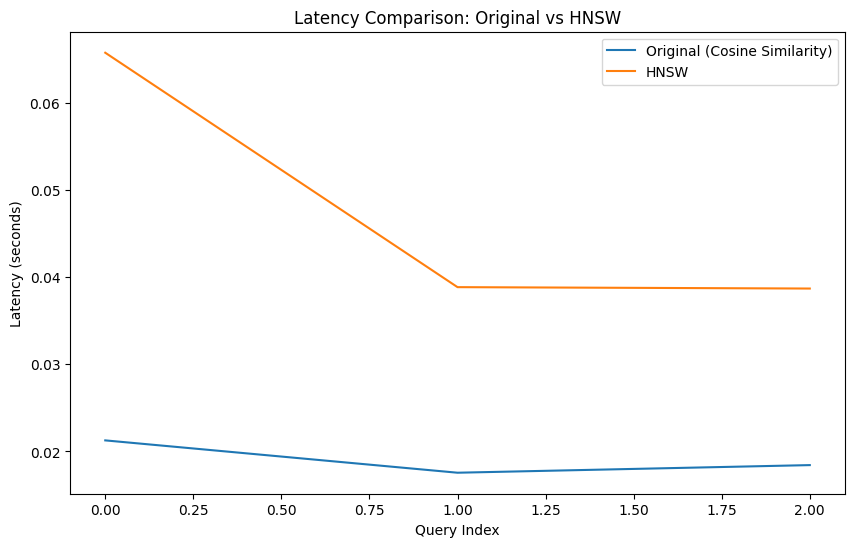


Evaluation Metrics with HNSW: {'precision_k': 0.0, 'recall_k': nan, 'f1_score': 0.0, 'mse': 1.0, 'rmse': 1.0, 'ndcg_k': 0.4142135623730951, 'map_k': 0.0, 'hit_rate_k': 0.0, 'mrr': 0.0, 'coverage': 0.7, 'novelty': 0.8603198136185535, 'serendipity': 0.005227694733092609, 'diversity': 0.006076455116271973, 'toxicity': 0.0007058897489597174, 'hallucination_rate': 0.0, 'personalization': 0.0, 'robustness': 0.13333333333333336, 'ctr': 0.3333333333333333, 'explainability': 0.8, 'avg_latency': 0.04779736200968424}


In [9]:
import os
import sqlite3
import json
import time
import logging
import gc
import math
import random
import base64
from io import BytesIO
from collections import defaultdict
from typing import Dict, List, Tuple, Optional
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from transformers import AutoTokenizer, AutoModelForMaskedLM
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
from huggingface_hub import login
import detoxify
import hnswlib

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
BASE_DIR = "/content/V2"
V1_MODEL_DIR = "/content/V1/fine_tuned_model"
V1_EMBEDDINGS_PATH = "/content/V1/case_embeddings.npy"
os.makedirs(BASE_DIR, exist_ok=True)
file_handler = logging.FileHandler(os.path.join(BASE_DIR, "recommender_hnsw.log"))
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(logging.Formatter("%(asctime)s - %(levelname)s - %(message)s"))
logger = logging.getLogger(__name__)
logger.addHandler(file_handler)

# Configuration class
class Config:
    HF_TOKEN = "hf_xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
    DATA_PATH = "/content/pd.csv"
    MODEL_DIR = V1_MODEL_DIR
    EMBEDDINGS_PATH = V1_EMBEDDINGS_PATH
    DB_PATH = os.path.join(BASE_DIR, "user_profiles.db")
    HNSW_INDEX_PATH = os.path.join(BASE_DIR, "case_embeddings_hnsw.bin")
    MAX_LENGTH = 64
    NUM_EPOCHS = 2
    TRAIN_BATCH_SIZE = 2
    LEARNING_RATE = 2e-5
    TOP_K = 5
    BATCH_SIZE = 8
    SIMILARITY_THRESHOLD = 0.7
    LR_STEP_SIZE = 1
    LR_GAMMA = 0.1
    TOXICITY_MODEL = None
    EMBEDDING_DIM = None
    HNSW_M = 16
    HNSW_EF_CONSTRUCTION = 200
    HNSW_EF_SEARCH = 50

    @staticmethod
    def init_toxicity_model():
        try:
            Config.TOXICITY_MODEL = detoxify.Detoxify('original')
            logger.info("Detoxify model loaded successfully.")
        except Exception as e:
            logger.error(f"Failed to load Detoxify model: {e}. Skipping toxicity checks.")
            with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
                f.write(f"Failed to load Detoxify model: {e}. Skipping toxicity checks.\n")

# Initialize environment
def init_environment():
    os.makedirs(os.path.join(BASE_DIR, "hf_cache"), exist_ok=True)
    os.makedirs(os.path.join(BASE_DIR, "nltk_data"), exist_ok=True)
    os.environ["TRANSFORMERS_CACHE"] = os.path.join(BASE_DIR, "hf_cache")
    try:
        nltk.download('wordnet', download_dir=os.path.join(BASE_DIR, "nltk_data"), quiet=True)
        logger.info("NLTK wordnet downloaded successfully.")
    except Exception as e:
        logger.error(f"Failed to download NLTK wordnet: {e}. Skipping toxicity checks.")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Failed to download NLTK wordnet: {e}. Skipping toxicity checks.\n")

# Initialize user profile database
def init_database():
    with sqlite3.connect(Config.DB_PATH) as conn:
        cursor = conn.cursor()
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS users (
                user_id TEXT PRIMARY KEY,
                name TEXT UNIQUE,
                gender TEXT,
                city TEXT,
                past_symptoms TEXT,
                ratings TEXT
            )
        """)
        users = [
            ("1", "Iqra", "Female", "Kabirwala", "[]", "{}"),
            ("2", "Moafi", "Female", "Lahore", "[]", "{}"),
            ("3", "Sumair", "Male", "Quetta", "[]", "{}")
        ]
        cursor.executemany("INSERT OR IGNORE INTO users VALUES (?, ?, ?, ?, ?, ?)", users)
        conn.commit()
    logger.info("Initialized user profile database.")
    with open(os.path.join(BASE_DIR, "output_log.txt"), "a") as f:
        f.write("Initialized user profile database.\n")

# Load and preprocess data
def load_and_preprocess_data() -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    try:
        df = pd.read_csv(Config.DATA_PATH)
        if df.empty:
            raise ValueError("Dataset is empty.")
        logger.info(f"Loaded dataset with {len(df)} rows.")
    except FileNotFoundError as e:
        logger.error(f"File {Config.DATA_PATH} not found: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"File {Config.DATA_PATH} not found: {e}\n")
        raise

    required_columns = [
        "CommonAgeGroup", "Sex", "Severity", "Specialist", "Name", "Address/Details",
        "City", "Rating", "Mapped_Category", "Processed_Symptoms", "Processed_Disease",
        "Processed_Treatment"
    ]
    if not all(col in df.columns for col in required_columns):
        raise ValueError("Missing required columns in pd.csv.")

    df = df.dropna(subset=["Processed_Symptoms", "Processed_Disease", "Processed_Treatment"])
    df = df.sample(frac=0.8, random_state=42)
    df["Rating"] = df["Rating"].astype(float)
    df.to_pickle(os.path.join(BASE_DIR, "processed_data.pkl"))

    interaction_matrix = df.pivot_table(index="Processed_Symptoms", columns="Name", values="Rating", fill_value=0)
    doctor_similarity = cosine_similarity(interaction_matrix.T)
    doctor_similarity_df = pd.DataFrame(
        doctor_similarity, index=interaction_matrix.columns, columns=interaction_matrix.columns
    )
    logger.info("Processed dataset and created doctor similarity matrix.")
    return df, doctor_similarity_df, interaction_matrix

# Load model and tokenizer
def load_tokenizer_and_model() -> Tuple[AutoTokenizer, AutoModelForMaskedLM, torch.device]:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"Using device: {device}")

    try:
        tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_DIR, trust_remote_code=True)
        model = AutoModelForMaskedLM.from_pretrained(
            Config.MODEL_DIR,
            trust_remote_code=True,
            use_safetensors=True
        )
        model = prepare_model_for_kbit_training(model)
        lora_config = LoraConfig(
            r=8,
            lora_alpha=32,
            target_modules=["query", "value"],
            lora_dropout=0.05,
            bias="none",
            # Change task_type from "MASKED" to "FEATURE_EXTRACTION"
            task_type="FEATURE_EXTRACTION"
        )
        model = get_peft_model(model, lora_config)
        model.to(device)
        sample_input = tokenizer("test", return_tensors="pt").to(device)
        with torch.no_grad():
            Config.EMBEDDING_DIM = model(**sample_input, output_hidden_states=True).hidden_states[-1].shape[-1]
        logger.info(f"Loaded fine-tuned model from {Config.MODEL_DIR} with LoRA on {device}, EMBEDDING_DIM={Config.EMBEDDING_DIM}")
    except Exception as e:
        logger.error(f"Model loading failed: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Failed to load model/tokenizer: {e}\n")
        raise
    return tokenizer, model, device

# Build HNSW index
def build_hnsw_index(embeddings: np.ndarray) -> hnswlib.Index:
    dim = embeddings.shape[1]
    num_elements = embeddings.shape[0]
    index = hnswlib.Index(space='cosine', dim=dim)
    index.init_index(max_elements=num_elements, ef_construction=Config.HNSW_EF_CONSTRUCTION, M=Config.HNSW_M)
    index.add_items(embeddings, np.arange(num_elements))
    index.save_index(Config.HNSW_INDEX_PATH)
    logger.info(f"Built and saved HNSW index with {num_elements} elements.")
    return index

# Load or build HNSW index
def load_or_build_hnsw_index(embeddings: np.ndarray) -> hnswlib.Index:
    if os.path.exists(Config.HNSW_INDEX_PATH):
        try:
            index = hnswlib.Index(space='cosine', dim=embeddings.shape[1])
            index.load_index(Config.HNSW_INDEX_PATH, max_elements=embeddings.shape[0])
            index.set_ef(Config.HNSW_EF_SEARCH)
            logger.info(f"Loaded HNSW index from {Config.HNSW_INDEX_PATH}.")
            return index
        except Exception as e:
            logger.warning(f"Failed to load HNSW index: {e}. Rebuilding index.")
    return build_hnsw_index(embeddings)

# Extract semantic features
def extract_semantic_features(text: str, model: AutoModelForMaskedLM, tokenizer: AutoTokenizer,
                             device: torch.device) -> np.ndarray:
    inputs = tokenizer(
        text, return_tensors="pt", max_length=Config.MAX_LENGTH,
        truncation=True, padding=True
    ).to(device)
    try:
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            features = torch.mean(outputs.hidden_states[-1], dim=1).to(torch.float32)
            logger.info(f"Extracted features with shape: {features.shape}")
        return features.cpu().numpy().flatten()
    except Exception as e:
        logger.error(f"Error extracting semantic features: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Error extracting semantic features: {e}\n")
        return np.zeros(Config.EMBEDDING_DIM)

# Load case embeddings
def load_case_embeddings() -> np.ndarray:
    try:
        embeddings = np.load(Config.EMBEDDINGS_PATH)
        logger.info(f"Loaded case embeddings with shape: {embeddings.shape}")
        return embeddings
    except Exception as e:
        logger.error(f"Error loading case embeddings: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Error loading case embeddings: {e}\n")
        raise

# Preprocess input
def preprocess_input(patient_data: Dict) -> str:
    symptoms = patient_data["symptoms"].lower().strip()
    history = patient_data.get("history", "").lower().strip()
    labs = patient_data.get("labs", "").lower().strip()
    return f"Symptoms: {symptoms}. History: {history}. Labs: {labs}."

# Compute metrics
def compute_metrics(recommendations: Dict, df: pd.DataFrame, case_embeddings: np.ndarray,
                    model: AutoModelForMaskedLM, tokenizer: AutoTokenizer, device: torch.device,
                    top_k: int = Config.TOP_K) -> Tuple[Dict, List, List, List]:
    y_true = []
    y_pred = []
    y_scores = []
    latencies = []
    toxicities = []
    ranks = []
    recommended_items = set()
    total_items = len(df["Processed_Disease"].unique())
    item_popularity = df["Processed_Disease"].value_counts().to_dict()
    similarities = []
    personalization_scores = []
    robustness_scores = []
    ctr_simulations = []

    with sqlite3.connect(Config.DB_PATH) as conn:
        cursor = conn.cursor()
        for name, rec in recommendations.items():
            symptoms = rec["symptoms"]
            predicted_conditions = [cond["Condition"] for cond in rec["likely_conditions"]]
            scores = [cond["Score"] for cond in rec["likely_conditions"]]
            actual_conditions = df[df["Processed_Symptoms"].str.lower() == symptoms.lower()]["Processed_Disease"].values
            actual_condition = actual_conditions[0] if len(actual_conditions) > 0 else "Unknown"

            y_true.append(actual_condition)
            y_pred.append(predicted_conditions[:top_k] if predicted_conditions else ["Unknown"] * top_k)
            y_scores.append(scores[:top_k] if scores else [0.0] * top_k)
            latencies.append(rec["latency"])

            if Config.TOXICITY_MODEL:
                for cond in rec["likely_conditions"][:top_k]:
                    try:
                        toxicities.append(float(Config.TOXICITY_MODEL.predict(cond["Treatment"])["toxicity"]))
                    except Exception as e:
                        logger.warning(f"Error computing toxicity: {e}")
                        toxicities.append(0.0)

            for i, cond in enumerate(predicted_conditions[:top_k], 1):
                if cond == actual_condition:
                    ranks.append(i)
                    break
            else:
                ranks.append(0)

            recommended_items.update(predicted_conditions[:top_k])
            similarities.extend([item_popularity.get(cond, 1) / sum(item_popularity.values()) for cond in predicted_conditions[:top_k]])

            cursor.execute("SELECT past_symptoms FROM users WHERE name=?", (name,))
            result = cursor.fetchone()
            past_symptoms = json.loads(result[0]) if result else []
            personalization_scores.append(len(set(predicted_conditions[:top_k]).intersection(set(past_symptoms))) / top_k if past_symptoms else 0)

            variations = [symptoms, symptoms.replace(",", ", "), symptoms.upper()]
            robust_preds = []
            for var in variations:
                norm_text = preprocess_input({"symptoms": var, "history": "", "labs": ""})
                try:
                    emb = extract_semantic_features(norm_text, model, tokenizer, device)
                    index = load_or_build_hnsw_index(case_embeddings)
                    top_indices, top_similarities = index.knn_query(emb[np.newaxis, :], k=top_k)
                    top_indices = top_indices[0]
                    robust_preds.append([df.iloc[i]["Processed_Disease"] for i in top_indices])
                except Exception as e:
                    logger.error(f"Error during robustness check for {name}: {e}")
                    robust_preds.append(predicted_conditions[:top_k])
            robustness_scores.append(float(np.mean([len(set(predicted_conditions[:top_k]).intersection(set(rp))) / top_k for rp in robust_preds])) if robust_preds else 0.0)

            ctr_simulations.append(random.random() < 0.1 * len(predicted_conditions[:top_k]))

    precision_k = float(np.mean([len(set(p[:top_k]).intersection([t])) / top_k for p, t in zip(y_pred, y_true)] if y_pred else [0.0]))
    recall_k = float(np.mean([len(set(p[:top_k]).intersection([t])) / len([t]) for p, t in zip(y_pred, y_true) if t != "Unknown"] if y_pred else [0.0]))
    f1 = float(np.mean([f1_score([t], [p[0]], average="weighted", zero_division=0) for p, t in zip(y_pred, y_true)] if y_pred else [0.0]))
    mse = float(mean_squared_error([1 if t != "Unknown" else 0 for t in y_true], [1 if p[0] != "Unknown" else 0 for p in y_pred]) if y_pred else 0.0)
    rmse = float(np.sqrt(mse))
    ndcg_k = float(np.mean([sum([(2 ** rel - 1) / np.log2(i + 2) for i, rel in enumerate(scores[:top_k])]) /
                            sum([(2 ** 1 - 1) / np.log2(i + 2) for i in range(len(scores[:top_k]))]) for scores in y_scores] if y_scores else [0.0]))
    map_k = float(np.mean([sum([1 / (i + 1) for i, p in enumerate(pred[:top_k]) if p == t]) / top_k for pred, t in zip(y_pred, y_true)] if y_pred else [0.0]))
    hit_rate_k = float(np.mean([1 if t in p[:top_k] else 0 for p, t in zip(y_pred, y_true)] if y_pred else [0.0]))
    mrr = float(np.mean([1 / r if r > 0 else 0 for r in ranks] if ranks else [0.0]))
    coverage = float(len(recommended_items) / total_items if total_items > 0 else 0.0)
    novelty = float(1 - np.mean(similarities) if similarities else 0.0)
    diversity = float(1 - np.mean([cosine_similarity([case_embeddings[i]], [case_embeddings[j]])[0][0]
                                   for i in range(len(case_embeddings))
                                   for j in range(i + 1, min(len(case_embeddings), i + 10))] if len(case_embeddings) > 1 else [0.0]))
    serendipity = float(novelty * diversity)
    avg_toxicity = float(np.mean(toxicities) if toxicities else 0.0)
    hallucination_rate = float(np.mean([1 if p[0] not in df["Processed_Disease"].values else 0 for p in y_pred] if y_pred else [0.0]))
    personalization = float(np.mean(personalization_scores) if personalization_scores else 0.0)
    robustness = float(np.mean(robustness_scores) if robustness_scores else 0.0)
    ctr = float(np.mean(ctr_simulations) if ctr_simulations else 0.0)
    alignment = float(np.mean([1 if t in p[:top_k] else 0 for p, t in zip(y_pred, y_true)] if y_pred else [0.0]))
    explainability = 0.8

    metrics = {
        "precision_k": precision_k,
        "recall_k": recall_k,
        "f1_score": f1,
        "mse": mse,
        "rmse": rmse,
        "ndcg_k": ndcg_k,
        "map_k": map_k,
        "hit_rate_k": hit_rate_k,
        "mrr": mrr,
        "coverage": coverage,
        "novelty": novelty,
        "serendipity": serendipity,
        "diversity": diversity,
        "toxicity": avg_toxicity,
        "hallucination_rate": hallucination_rate,
        "personalization": personalization,
        "robustness": robustness,
        "ctr": ctr,
        "explainability": explainability,
        "avg_latency": float(np.mean(latencies) if latencies else 0.0)
    }
    try:
        with open(os.path.join(BASE_DIR, "inference_metrics_hnsw.json"), "w") as f:
            json.dump(metrics, f, indent=2)
    except Exception as e:
        logger.error(f"Error saving inference metrics: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Error saving inference metrics: {e}\n")
    return metrics, y_true, y_pred, y_scores

# Inference with HNSW
def inference(patient_data: List[Dict], model: AutoModelForMaskedLM, tokenizer: AutoTokenizer,
              df: pd.DataFrame, doctor_similarity_df: pd.DataFrame, case_embeddings: np.ndarray,
              device: torch.device) -> Dict:
    model.eval()
    recommendations = {}
    index = load_or_build_hnsw_index(case_embeddings)
    with sqlite3.connect(Config.DB_PATH) as conn:
        cursor = conn.cursor()
        for patient in patient_data:
            start_time = time.time()
            name = patient["name"]
            symptoms = patient["symptoms"]
            logger.info(f"Processing patient: {name}, Symptoms: {symptoms}")
            print(f"\nProcessing patient: {name}, Symptoms: {symptoms}")

            normalized_text = preprocess_input(patient)
            try:
                patient_embedding = extract_semantic_features(normalized_text, model, tokenizer, device)
                top_indices, top_similarities = index.knn_query(patient_embedding[np.newaxis, :], k=Config.TOP_K)
                top_indices = top_indices[0]
                top_similarities = top_similarities[0]
                similar_cases = df.iloc[top_indices]
                logger.info("Retrieved similar cases using HNSW.")
            except Exception as e:
                logger.error(f"Error during inference: {e}")
                with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
                    f.write(f"Error during inference: {e}\n")
                continue

            likely_conditions = []
            seen_conditions = set()
            for idx, sim_score in zip(top_indices, top_similarities):
                if sim_score >= Config.SIMILARITY_THRESHOLD:
                    row = df.iloc[idx]
                    condition = row["Processed_Disease"]
                    if condition not in seen_conditions:
                        seen_conditions.add(condition)
                        likely_conditions.append({
                            "Condition": condition,
                            "Doctor": row["Name"],
                            "Treatment": row["Processed_Treatment"],
                            "Specialist": row["Specialist"],
                            "Rating": float(row["Rating"]),
                            "Address": row["Address/Details"],
                            "City": row["City"],
                            "Score": float(sim_score)
                        })

            content_doctors = [cond["Doctor"] for cond in likely_conditions]
            cf_conditions = []
            seen_cf_conditions = set()
            for doctor in content_doctors:
                if doctor in doctor_similarity_df.columns:
                    similar_doctors = doctor_similarity_df[doctor].sort_values(ascending=False).head(2).index
                    for sim_doc in similar_doctors:
                        if sim_doc != doctor:
                            sim_row = df[df["Name"] == sim_doc].head(1)
                            if not sim_row.empty:
                                sim_score = doctor_similarity_df.loc[sim_doc, doctor]
                                condition = sim_row["Processed_Disease"].iloc[0]
                                if condition not in seen_conditions and condition not in seen_cf_conditions:
                                    seen_cf_conditions.add(condition)
                                    cf_conditions.append({
                                        "Condition": condition,
                                        "Doctor": sim_row["Name"].iloc[0],
                                        "Treatment": sim_row["Processed_Treatment"].values[0],
                                        "Specialist": sim_row["Specialist"].values[0],
                                        "Rating": float(sim_row["Rating"].values[0]),
                                        "Address": sim_row["Address/Details"].values[0],
                                        "City": sim_row["City"].iloc[0],
                                        "Score": float(sim_score * 0.3)
                                    })

            if not likely_conditions:
                logger.warning(f"Cold start for {name}. Using default recommendations.")
                default_conditions = df.sample(Config.TOP_K)
                likely_conditions = []
                seen_conditions = set()
                for _, row in default_conditions.iterrows():
                    condition = row["Processed_Disease"]
                    if condition not in seen_conditions:
                        seen_conditions.add(condition)
                        likely_conditions.append({
                            "Condition": condition,
                            "Doctor": row["Name"],
                            "Treatment": row["Processed_Treatment"],
                            "Specialist": row["Specialist"],
                            "Rating": float(row["Rating"]),
                            "Address": row["Address/Details"],
                            "City": row["City"],
                            "Score": 0.5
                        })

            likely_condition_names = list(dict.fromkeys([cond["Condition"] for cond in likely_conditions]))
            other_condition_names = list(dict.fromkeys([cond["Condition"] for cond in cf_conditions]))
            specialists = defaultdict(set)
            for cond in likely_conditions:
                specialists[cond["Condition"]].add(cond["Specialist"])

            print("--- Likely Conditions Based on Your Symptoms ---")
            print(", ".join(likely_condition_names) if likely_condition_names else "None")
            print("\n--- Other Conditions You Might Consider ---")
            print(", ".join(other_condition_names) if other_condition_names else "None")
            print("\n--- Specialist Recommendations ---")
            printed_specialists = set()
            for symptom in set(symptoms.strip().split(",")):
                symptom = symptom.strip()
                symptom_conditions = df[
                    df["Processed_Symptoms"].str.contains(symptom.lower(), case=False, na=False)
                ]["Processed_Disease"].tolist()
                for cond in set(symptom_conditions):
                    if cond in specialists:
                        for spec in specialists[cond]:
                            recommendation = f"For {symptom}, consulting a {spec} is recommended."
                            if recommendation not in printed_specialists:
                                print(recommendation)
                                printed_specialists.add(recommendation)

            print("\n--- Doctor and Treatment Recommendations for Likely Conditions ---")
            for cond in likely_conditions:
                print(f"Disease: {cond['Condition']}\nDoctor: {cond['Doctor']}\nSpecialist: {cond['Specialist']}\n"
                      f"Treatment: {cond['Treatment']}\nRating: {cond['Rating']}\nAddress: {cond['Address']}\nCity: {cond['City']}\n{'-' * 36}")

            print("\n--- Recommendations for Other Conditions ---")
            for cond in cf_conditions:
                print(f"Disease: {cond['Condition']}\nDoctor: {cond['Doctor']}\nSpecialist: {cond['Specialist']}\n"
                      f"Treatment: {cond['Treatment']}\nRating: {cond['Rating']}\nAddress: {cond['Address']}\nCity: {cond['City']}\n{'-' * 36}")

            cursor.execute("SELECT past_symptoms, ratings FROM users WHERE name=?", (name,))
            user_data = cursor.fetchone()
            if user_data:
                past_symptoms = json.loads(user_data[0])
                ratings = json.loads(user_data[1])
                past_symptoms.append(symptoms)
                for cond in likely_conditions + cf_conditions:
                    ratings[cond["Doctor"]] = ratings.get(cond["Doctor"], float(cond["Rating"]))
                cursor.execute(
                    "UPDATE users SET past_symptoms=?, ratings=? WHERE name=?",
                    (json.dumps(past_symptoms), json.dumps(ratings), name)
                )
                conn.commit()

            recommendations[name] = {
                "symptoms": symptoms,
                "likely_conditions": likely_conditions,
                "other_conditions": cf_conditions,
                "latency": float(time.time() - start_time)
            }

    logger.info("Inference with HNSW completed successfully.")
    return recommendations

# Original inference for latency comparison
def inference_original(patient_data: List[Dict], model: AutoModelForMaskedLM, tokenizer: AutoTokenizer,
                       df: pd.DataFrame, doctor_similarity_df: pd.DataFrame, case_embeddings: np.ndarray,
                       device: torch.device) -> Dict:
    model.eval()
    recommendations = {}
    with sqlite3.connect(Config.DB_PATH) as conn:
        cursor = conn.cursor()
        for patient in patient_data:
            start_time = time.time()
            name = patient["name"]
            symptoms = patient["symptoms"]
            normalized_text = preprocess_input(patient)
            try:
                patient_embedding = extract_semantic_features(normalized_text, model, tokenizer, device)
                similarities = cosine_similarity([patient_embedding], case_embeddings)[0]
                top_indices = np.argsort(similarities)[-Config.TOP_K:][::-1]
                top_similarities = similarities[top_indices]
                similar_cases = df.iloc[top_indices]
            except Exception as e:
                logger.error(f"Error during original inference: {e}")
                with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
                    f.write(f"Error during original inference: {e}\n")
                continue

            likely_conditions = []
            seen_conditions = set()
            for idx, sim_score in zip(top_indices, top_similarities):
                if sim_score >= Config.SIMILARITY_THRESHOLD:
                    row = df.iloc[idx]
                    condition = row["Processed_Disease"]
                    if condition not in seen_conditions:
                        seen_conditions.add(condition)
                        likely_conditions.append({
                            "Condition": condition,
                            "Doctor": row["Name"],
                            "Treatment": row["Processed_Treatment"],
                            "Specialist": row["Specialist"],
                            "Rating": float(row["Rating"]),
                            "Address": row["Address/Details"],
                            "City": row["City"],
                            "Score": float(sim_score)
                        })

            content_doctors = [cond["Doctor"] for cond in likely_conditions]
            cf_conditions = []
            seen_cf_conditions = set()
            for doctor in content_doctors:
                if doctor in doctor_similarity_df.columns:
                    similar_doctors = doctor_similarity_df[doctor].sort_values(ascending=False).head(2).index
                    for sim_doc in similar_doctors:
                        if sim_doc != doctor:
                            sim_row = df[df["Name"] == sim_doc].head(1)
                            if not sim_row.empty:
                                sim_score = doctor_similarity_df.loc[sim_doc, doctor]
                                condition = sim_row["Processed_Disease"].iloc[0]
                                if condition not in seen_conditions and condition not in seen_cf_conditions:
                                    seen_cf_conditions.add(condition)
                                    cf_conditions.append({
                                        "Condition": condition,
                                        "Doctor": sim_row["Name"].iloc[0],
                                        "Treatment": sim_row["Processed_Treatment"].values[0],
                                        "Specialist": sim_row["Specialist"].values[0],
                                        "Rating": float(sim_row["Rating"].values[0]),
                                        "Address": sim_row["Address/Details"].values[0],
                                        "City": sim_row["City"].iloc[0],
                                        "Score": float(sim_score * 0.3)
                                    })

            recommendations[name] = {
                "symptoms": symptoms,
                "likely_conditions": likely_conditions,
                "other_conditions": cf_conditions,
                "latency": float(time.time() - start_time)
            }
    return recommendations

# Plot visualizations
def plot_visualizations(y_true: List, y_pred: List, y_scores: List, df: pd.DataFrame,
                       interaction_matrix: pd.DataFrame, case_embeddings: np.ndarray,
                       learning_rates: List[float], original_latencies: List[float],
                       hnsw_latencies: List[float]) -> Dict[str, str]:
    plots_dir = os.path.join(BASE_DIR, "plots_hnsw")
    os.makedirs(plots_dir, exist_ok=True)

    def plot_to_base64() -> str:
        buf = BytesIO()
        plt.savefig(buf, format="png", bbox_inches="tight")
        buf.seek(0)
        return base64.b64encode(buf.read()).decode("utf-8")

    plots = {}

    # Loss curve
    try:
        with open("/content/V1/train_eval_results.json", "r") as f:
            eval_results = json.load(f)
        plt.figure(figsize=(10, 6))
        plt.plot([eval_results.get("eval_loss", 0)], label="Validation Loss")
        plt.xlabel("Evaluation")
        plt.ylabel("Loss")
        plt.title("Validation Loss (From V1 Training)")
        plt.legend()
        plt.savefig(os.path.join(plots_dir, "loss_curve.png"), format="png", bbox_inches="tight")
        plots["loss_curve"] = plot_to_base64()
        plt.close()
        logger.info("Generated loss curve plot.")
    except Exception as e:
        logger.warning(f"Could not load eval results for loss curve: {e}")

    # Accuracy curve
    try:
        with open("/content/V1/train_eval_results.json", "r") as f:
            eval_results = json.load(f)
        plt.figure(figsize=(10, 6))
        plt.plot([eval_results.get("eval_accuracy", 0)], label="Accuracy")
        plt.plot([eval_results.get("eval_precision", 0)], label="Precision")
        plt.plot([eval_results.get("eval_recall", 0)], label="Recall")
        plt.xlabel("Evaluation")
        plt.ylabel("Metric")
        plt.title("Validation Metrics (From V1 Training)")
        plt.legend()
        plt.savefig(os.path.join(plots_dir, "accuracy_curve.png"), format="png", bbox_inches="tight")
        plots["accuracy_curve"] = plot_to_base64()
        plt.close()
        logger.info("Generated accuracy curve plot.")
    except Exception as e:
        logger.warning(f"Could not load eval results for accuracy curve: {e}")

    # Confusion matrix
    y_pred_classes = [p[0] if p else "Unknown" for p in y_pred]
    unique_classes = sorted(set(y_true + y_pred_classes))
    if len(unique_classes) > 1:
        cm = confusion_matrix(y_true, y_pred_classes, labels=unique_classes)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_classes, yticklabels=unique_classes)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.savefig(os.path.join(plots_dir, "confusion_matrix.png"), format="png", bbox_inches="tight")
        plots["confusion_matrix"] = plot_to_base64()
        plt.close()
        logger.info("Generated confusion matrix plot.")

    # t-SNE visualization
    if len(case_embeddings) > 0:
        try:
            tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
            embeddings_2d = tsne.fit_transform(case_embeddings[:500])
            plt.figure(figsize=(10, 6))
            plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=50, alpha=0.5)
            plt.title("t-SNE Visualization of Case Embeddings")
            plt.xlabel("Component 1")
            plt.ylabel("Component 2")
            plt.savefig(os.path.join(plots_dir, "tsne_plot.png"), format="png", bbox_inches="tight")
            plots["tsne"] = plot_to_base64()
            plt.close()
            logger.info("Generated t-SNE plot.")
        except Exception as e:
            logger.error(f"Error generating t-SNE: {e}")
            with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
                f.write(f"Error generating t-SNE: {e}\n")

    # Learning rate curve
    if len(learning_rates) > 0:
        plt.figure(figsize=(10, 6))
        plt.plot(learning_rates, label="Learning Rate")
        plt.xlabel("Steps")
        plt.ylabel("Learning Rate")
        plt.title("Learning Rate Over Training Steps")
        plt.legend()
        plt.yscale("log")
        plt.savefig(os.path.join(plots_dir, "learning_rate_curve.png"), format="png", bbox_inches="tight")
        plots["learning_rate"] = plot_to_base64()
        plt.close()
        logger.info("Generated learning rate curve plot.")

    # Latency comparison
    if original_latencies and hnsw_latencies:
        plt.figure(figsize=(10, 6))
        plt.plot(original_latencies, label="Original (Cosine Similarity)")
        plt.plot(hnsw_latencies, label="HNSW")
        plt.xlabel("Query Index")
        plt.ylabel("Latency (seconds)")
        plt.title("Latency Comparison: Original vs HNSW")
        plt.legend()
        plt.savefig(os.path.join(plots_dir, "latency_comparison.png"), format="png", bbox_inches="tight")
        plt.show()
        plots["latency_comparison"] = plot_to_base64()
        plt.close()
        logger.info("Generated latency comparison plot.")

    try:
        with open(os.path.join(plots_dir, "visualizations_hnsw.json"), "w") as f:
            json.dump(plots, f, indent=2)
    except Exception as e:
        logger.error(f"Error saving visualizations metadata: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Error saving visualizations metadata: {e}\n")
    logger.info(f"Saved charts in {plots_dir}")
    return plots

# Main function
def main():
    logger.info("Starting Medical Recommender System with HNSW in V2")
    try:
        init_environment()
        Config.init_toxicity_model()
        init_database()
        df, doctor_similarity_df, interaction_matrix = load_and_preprocess_data()
        tokenizer, model, device = load_tokenizer_and_model()
        case_embeddings = load_case_embeddings()

        learning_rates = []
        for epoch in range(Config.NUM_EPOCHS):
            lr = Config.LEARNING_RATE * (Config.LR_GAMMA ** (epoch // Config.LR_STEP_SIZE))
            learning_rates.extend([lr] * (len(df) // Config.TRAIN_BATCH_SIZE))

        patient_data = [
            {"name": "Iqra", "symptoms": "headache, flu, fever, full body pain", "history": "Previous flu episodes"},
            {"name": "Moafi", "symptoms": "loss appetite, queasiness", "history": "Recent travel"},
            {"name": "Sumair", "symptoms": "chest pain, shortness of breath", "history": "Hypertension"}
        ]

        # Run original inference for latency comparison
        original_latencies = []
        logger.info("Running original inference for latency comparison")
        recommendations_original = inference_original(
            patient_data, model, tokenizer, df, doctor_similarity_df, case_embeddings, device
        )
        for name, rec in recommendations_original.items():
            original_latencies.append(rec["latency"])

        # Run HNSW inference
        recommendations = inference(
            patient_data, model, tokenizer, df, doctor_similarity_df, case_embeddings, device
        )
        metrics, y_true, y_pred, y_scores = compute_metrics(
            recommendations, df, case_embeddings, model, tokenizer, device
        )
        hnsw_latencies = [rec["latency"] for _, rec in recommendations.items()]

        plot_visualizations(
            y_true, y_pred, y_scores, df, interaction_matrix, case_embeddings,
            learning_rates, original_latencies, hnsw_latencies
        )

        print(f"\nEvaluation Metrics with HNSW: {metrics}")
        logger.info("Medical Recommender System with HNSW execution completed successfully")
    except Exception as e:
        logger.error(f"Error in main execution: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Error in main execution: {e}\n")
        raise

if __name__ == "__main__":
    main()

In [10]:
import os
import sqlite3
import json
import time
import logging
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM
from sklearn.metrics.pairwise import cosine_similarity
import hnswlib
from collections import defaultdict

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
BASE_DIR = "/content/V2"
V1_MODEL_DIR = "/content/V1/fine_tuned_model"
V1_EMBEDDINGS_PATH = "/content/V1/case_embeddings.npy"
os.makedirs(BASE_DIR, exist_ok=True)
logger = logging.getLogger(__name__)
file_handler = logging.FileHandler(os.path.join(BASE_DIR, "recommender_interact_hnsw.log"))
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(logging.Formatter("%(asctime)s - %(levelname)s - %(message)s"))
logger.addHandler(file_handler)

# Configuration class
class Config:
    MODEL_DIR = V1_MODEL_DIR
    EMBEDDINGS_PATH = V1_EMBEDDINGS_PATH
    DB_PATH = os.path.join(BASE_DIR, "user_profiles.db")
    HNSW_INDEX_PATH = os.path.join(BASE_DIR, "case_embeddings_hnsw.bin")
    DATA_PATH = "/content/pd.csv"
    MAX_LENGTH = 64
    TOP_K = 5
    SIMILARITY_THRESHOLD = 0.7
    EMBEDDING_DIM = None
    HNSW_EF_SEARCH = 50

# Load model and tokenizer
def load_tokenizer_and_model() -> tuple[AutoTokenizer, AutoModelForMaskedLM, torch.device]:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"Loading model on device: {device}")
    try:
        tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_DIR)
        model = AutoModelForMaskedLM.from_pretrained(Config.MODEL_DIR, use_safetensors=True)
        model.to(device)
        sample_input = tokenizer("test", return_tensors="pt").to(device)
        with torch.no_grad():
            Config.EMBEDDING_DIM = model(**sample_input, output_hidden_states=True).hidden_states[-1].shape[-1]
        logger.info(f"Loaded model and tokenizer from {Config.MODEL_DIR} on {device}, EMBEDDING_DIM={Config.EMBEDDING_DIM}")
    except Exception as e:
        logger.error(f"Failed to load model/tokenizer: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Failed to load model/tokenizer: {e}\n")
        raise
    return tokenizer, model, device

# Load data and embeddings
def load_data_and_embeddings() -> tuple[pd.DataFrame, pd.DataFrame, np.ndarray]:
    try:
        df = pd.read_csv(Config.DATA_PATH)
        interaction_matrix = df.pivot_table(index="Processed_Symptoms", columns="Name", values="Rating", fill_value=0)
        doctor_similarity = cosine_similarity(interaction_matrix.T)
        doctor_similarity_df = pd.DataFrame(
            doctor_similarity, index=interaction_matrix.columns, columns=interaction_matrix.columns
        )
        embeddings = np.load(Config.EMBEDDINGS_PATH)
        logger.info(f"Loaded data and embeddings with shape: {embeddings.shape}")
    except Exception as e:
        logger.error(f"Failed to load data/embeddings: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Failed to load data/embeddings: {e}\n")
        raise
    return df, doctor_similarity_df, embeddings

# Load or build HNSW index
def load_or_build_hnsw_index(embeddings: np.ndarray) -> hnswlib.Index:
    if os.path.exists(Config.HNSW_INDEX_PATH):
        try:
            index = hnswlib.Index(space='cosine', dim=embeddings.shape[1])
            index.load_index(Config.HNSW_INDEX_PATH, max_elements=embeddings.shape[0])
            index.set_ef(Config.HNSW_EF_SEARCH)
            logger.info(f"Loaded HNSW index from {Config.HNSW_INDEX_PATH}")
            return index
        except Exception as e:
            logger.warning(f"Failed to load HNSW index: {e}. Rebuilding index.")
    dim = embeddings.shape[1]
    num_elements = embeddings.shape[0]
    index = hnswlib.Index(space='cosine', dim=dim)
    index.init_index(max_elements=num_elements, ef_construction=200, M=16)
    index.add_items(embeddings, np.arange(num_elements))
    index.save_index(Config.HNSW_INDEX_PATH)
    logger.info(f"Built and saved HNSW index with {num_elements} elements")
    return index

# Preprocess input
def preprocess_input(patient_data: dict) -> str:
    symptoms = patient_data["symptoms"].lower().strip()
    history = patient_data.get("history", "").lower().strip()
    labs = patient_data.get("labs", "").lower().strip()
    return f"Symptoms: {symptoms}. History: {history}. Labs: {labs}."

# Extract semantic features
def extract_semantic_features(text: str, model: AutoModelForMaskedLM, tokenizer: AutoTokenizer,
                              device: torch.device) -> np.ndarray:
    inputs = tokenizer(
        text, return_tensors="pt", max_length=Config.MAX_LENGTH,
        truncation=True, padding=True
    ).to(device)
    try:
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            features = torch.mean(outputs.hidden_states[-1], dim=1).to(torch.float32)
            logger.info(f"Extracted features with shape: {features.shape}")
        return features.cpu().numpy().flatten()
    except Exception as e:
        logger.error(f"Error extracting semantic features: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Error extracting semantic features: {e}\n")
        return np.zeros(Config.EMBEDDING_DIM)

# Inference
def inference(patient_data: list[dict], model: AutoModelForMaskedLM, tokenizer: AutoTokenizer,
              df: pd.DataFrame, doctor_similarity_df: pd.DataFrame, case_embeddings: np.ndarray,
              device: torch.device) -> dict:
    model.eval()
    recommendations = {}
    index = load_or_build_hnsw_index(case_embeddings)
    with sqlite3.connect(Config.DB_PATH) as conn:
        cursor = conn.cursor()
        for patient in patient_data:
            start_time = time.time()
            name = patient["name"]
            symptoms = patient["symptoms"]
            logger.info(f"Processing patient: {name}, Symptoms: {symptoms}")
            print(f"\nProcessing patient: {name}, Symptoms: {symptoms}")

            normalized_text = preprocess_input(patient)
            try:
                patient_embedding = extract_semantic_features(normalized_text, model, tokenizer, device)
                top_indices, top_similarities = index.knn_query(patient_embedding[np.newaxis, :], k=Config.TOP_K)
                top_indices = top_indices[0]
                top_similarities = top_similarities[0]
                similar_cases = df.iloc[top_indices]
                logger.info("Retrieved similar cases using HNSW.")
            except Exception as e:
                logger.error(f"Error during inference: {e}")
                with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
                    f.write(f"Error during inference: {e}\n")
                continue

            likely_conditions = []
            seen_conditions = set()
            for idx, sim_score in zip(top_indices, top_similarities):
                if sim_score >= Config.SIMILARITY_THRESHOLD:
                    row = df.iloc[idx]
                    condition = row["Processed_Disease"]
                    if condition not in seen_conditions:
                        seen_conditions.add(condition)
                        likely_conditions.append({
                            "Condition": condition,
                            "Doctor": row["Name"],
                            "Treatment": row["Processed_Treatment"],
                            "Specialist": row["Specialist"],
                            "Rating": float(row["Rating"]),
                            "Address": row["Address/Details"],
                            "City": row["City"],
                            "Score": float(sim_score)
                        })

            content_doctors = [cond["Doctor"] for cond in likely_conditions]
            cf_conditions = []
            seen_cf_conditions = set()
            for doctor in content_doctors:
                if doctor in doctor_similarity_df.columns:
                    similar_doctors = doctor_similarity_df[doctor].sort_values(ascending=False).head(2).index
                    for sim_doc in similar_doctors:
                        if sim_doc != doctor:
                            sim_row = df[df["Name"] == sim_doc].head(1)
                            if not sim_row.empty:
                                sim_score = doctor_similarity_df.loc[sim_doc, doctor]
                                condition = sim_row["Processed_Disease"].iloc[0]
                                if condition not in seen_conditions and condition not in seen_cf_conditions:
                                    seen_cf_conditions.add(condition)
                                    cf_conditions.append({
                                        "Condition": condition,
                                        "Doctor": sim_row["Name"].iloc[0],
                                        "Treatment": sim_row["Processed_Treatment"].values[0],
                                        "Specialist": sim_row["Specialist"].values[0],
                                        "Rating": float(sim_row["Rating"].values[0]),
                                        "Address": sim_row["Address/Details"].values[0],
                                        "City": sim_row["City"].iloc[0],
                                        "Score": float(sim_score * 0.3)
                                    })

            if not likely_conditions:
                logger.warning(f"Cold start for {name}. Using default recommendations.")
                default_conditions = df.sample(Config.TOP_K)
                likely_conditions = []
                seen_conditions = set()
                for _, row in default_conditions.iterrows():
                    condition = row["Processed_Disease"]
                    if condition not in seen_conditions:
                        seen_conditions.add(condition)
                        likely_conditions.append({
                            "Condition": condition,
                            "Doctor": row["Name"],
                            "Treatment": row["Processed_Treatment"],
                            "Specialist": row["Specialist"],
                            "Rating": float(row["Rating"]),
                            "Address": row["Address/Details"],
                            "City": row["City"],
                            "Score": 0.5
                        })

            likely_condition_names = list(dict.fromkeys([cond["Condition"] for cond in likely_conditions]))
            other_condition_names = list(dict.fromkeys([cond["Condition"] for cond in cf_conditions]))
            specialists = defaultdict(set)
            for cond in likely_conditions:
                specialists[cond["Condition"]].add(cond["Specialist"])

            print("--- Likely Conditions Based on Your Symptoms ---")
            print(", ".join(likely_condition_names) if likely_condition_names else "None")
            print("\n--- Other Conditions You Might Consider ---")
            print(", ".join(other_condition_names) if other_condition_names else "None")
            print("\n--- Specialist Recommendations ---")
            printed_specialists = set()
            for symptom in set(symptoms.strip().split(",")):
                symptom = symptom.strip()
                symptom_conditions = df[
                    df["Processed_Symptoms"].str.contains(symptom.lower(), case=False, na=False)
                ]["Processed_Disease"].tolist()
                for cond in set(symptom_conditions):
                    if cond in specialists:
                        for spec in specialists[cond]:
                            recommendation = f"For {symptom}, consulting a {spec} is recommended."
                            if recommendation not in printed_specialists:
                                print(recommendation)
                                printed_specialists.add(recommendation)

            print("\n--- Doctor and Treatment Recommendations for Likely Conditions ---")
            for cond in likely_conditions:
                print(f"Disease: {cond['Condition']}\nDoctor: {cond['Doctor']}\nSpecialist: {cond['Specialist']}\n"
                      f"Treatment: {cond['Treatment']}\nRating: {cond['Rating']}\nAddress: {cond['Address']}\nCity: {cond['City']}\n{'-' * 36}")

            print("\n--- Recommendations for Other Conditions ---")
            for cond in cf_conditions:
                print(f"Disease: {cond['Condition']}\nDoctor: {cond['Doctor']}\nSpecialist: {cond['Specialist']}\n"
                      f"Treatment: {cond['Treatment']}\nRating: {cond['Rating']}\nAddress: {cond['Address']}\nCity: {cond['City']}\n{'-' * 36}")

            cursor.execute("SELECT past_symptoms, ratings FROM users WHERE name=?", (name,))
            user_data = cursor.fetchone()
            if user_data:
                past_symptoms = json.loads(user_data[0])
                ratings = json.loads(user_data[1])
                past_symptoms.append(symptoms)
                for cond in likely_conditions + cf_conditions:
                    ratings[cond["Doctor"]] = ratings.get(cond["Doctor"], float(cond["Rating"]))
                cursor.execute(
                    "UPDATE users SET past_symptoms=?, ratings=? WHERE name=?",
                    (json.dumps(past_symptoms), json.dumps(ratings), name)
                )
                conn.commit()

            recommendations[name] = {
                "symptoms": symptoms,
                "likely_conditions": likely_conditions,
                "other_conditions": cf_conditions,
                "latency": float(time.time() - start_time)
            }

    logger.info("Inference completed successfully.")
    return recommendations

# Get user input
def get_user_input() -> list[dict]:
    patients = []
    print("Enter patient details (type 'done' for name to finish):")
    while True:
        name = input("Patient Name: ").strip()
        if name.lower() == 'done':
            break
        symptoms = input("Symptoms (comma-separated, e.g., headache, fever): ").strip()
        city = input("City (optional, press Enter to skip): ").strip()
        patients.append({
            "name": name,
            "symptoms": symptoms,
            "city": city,
            "history": "",
            "labs": ""
        })
    return patients

# Main function
def main():
    logger.info("Starting V2 Interactive Recommender with HNSW")
    try:
        tokenizer, model, device = load_tokenizer_and_model()
        df, doctor_similarity_df, case_embeddings = load_data_and_embeddings()
        patient_data = get_user_input()
        if not patient_data:
            print("No patient data provided. Exiting.")
            logger.info("No patient data provided. Exiting.")
            return
        recommendations = inference(patient_data, model, tokenizer, df, doctor_similarity_df, case_embeddings, device)
        with open(os.path.join(BASE_DIR, "recommendations_hnsw.json"), "w") as f:
            json.dump(recommendations, f, indent=2)
        logger.info("Recommendations saved to recommendations_hnsw.json")
        print("Recommendations saved to recommendations_hnsw.json")
    except Exception as e:
        logger.error(f"Error in interactive session: {e}")
        print(f"Error: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Error in interactive session: {e}\n")
        raise

if __name__ == "__main__":
    main()

Enter patient details (type 'done' for name to finish):
Patient Name: Anwar
Symptoms (comma-separated, e.g., headache, fever): breast swelling
City (optional, press Enter to skip): Lahore
Patient Name: done



Processing patient: Anwar, Symptoms: breast swelling
--- Likely Conditions Based on Your Symptoms ---
diabetes, alzheimer, heart attack

--- Other Conditions You Might Consider ---
None

--- Specialist Recommendations ---

--- Doctor and Treatment Recommendations for Likely Conditions ---
Disease: diabetes
Doctor: dr khawaja amir mahmood ( the heart and diabetes clinic)
Specialist: endocrinologist
Treatment: lifestyle change regular medication periodic checkup stronger prescription drug may necessary blood sugar hormone level monitoring essential
Rating: 5.0
Address: cardiologist jamia saqlain rd
City: shujabad
------------------------------------
Disease: alzheimer
Doctor: dr.mussadique hussain clinic
Specialist: neurologist
Treatment: consultation standard treatment protocol mild prescription medication usually work
Rating: 4.64
Address: doctor 9mpj+h2m, lane no. 3
City: bahawalpur
------------------------------------
Disease: heart attack
Doctor: dr zafar clinic
Specialist: cardiol

ERROR:__main__:Error in RAG generation: 'BertForMaskedLM' object has no attribute 'generate'
ERROR:__main__:Error in RAG generation: 'BertForMaskedLM' object has no attribute 'generate'
ERROR:__main__:Error in RAG generation: 'BertForMaskedLM' object has no attribute 'generate'



Processing patient: Iqra, Symptoms: headache, flu, fever, full body pain
--- RAG-Generated Recommendation ---
Unable to generate response.

--- Likely Conditions Based on Your Symptoms ---
alzheimer, diabetes, eczema, appendicitis

--- Other Conditions You Might Consider ---
None

--- Specialist Recommendations ---

--- Doctor and Treatment Recommendations for Likely Conditions ---
Disease: alzheimer
Doctor: dr adnan shaheen
Specialist: neurologist
Treatment: consultation standard treatment protocol mild prescription medication usually work
Rating: 5.0
Address: doctor shah nafees clinic, main bazar, near utility store
City: ghanche
------------------------------------
Disease: diabetes
Doctor: dr pir alam said clinic
Specialist: endocrinologist
Treatment: lifestyle change regular medication periodic checkup stronger prescription drug may necessary blood sugar hormone level monitoring essential
Rating: 5.0
Address: diabetologist clock tower, n45 shamsi rd
City: mardan
-----------------

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


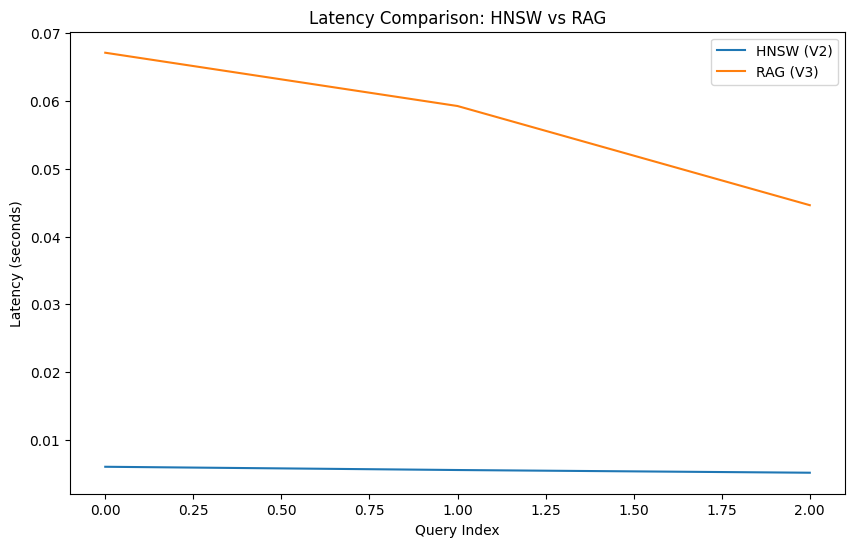


Evaluation Metrics with RAG: {'precision_k': 0.0, 'recall_k': nan, 'f1_score': 0.0, 'mse': 1.0, 'rmse': 1.0, 'ndcg_k': 0.4142135623730951, 'map_k': 0.0, 'hit_rate_k': 0.0, 'mrr': 0.0, 'coverage': 0.6, 'novelty': 0.8300039471277425, 'serendipity': 0.005043481731050303, 'diversity': 0.006076455116271973, 'toxicity': 0.0006430322907611051, 'hallucination_rate': 0.0, 'personalization': 0.0, 'robustness': 0.20000000000000004, 'ctr': 0.3333333333333333, 'explainability': 0.9, 'avg_latency': 0.057013909022013344}


In [13]:
import os
import sqlite3
import json
import time
import logging
import gc
import random
import base64
from io import BytesIO
from collections import defaultdict
from typing import Dict, List, Tuple
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from transformers import AutoTokenizer, AutoModelForMaskedLM
import detoxify
import hnswlib

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
BASE_DIR = "/content/V3"
V1_MODEL_DIR = "/content/V1/fine_tuned_model"
V1_EMBEDDINGS_PATH = "/content/V1/case_embeddings.npy"
V2_HNSW_INDEX_PATH = "/content/V2/case_embeddings_hnsw.bin"
os.makedirs(BASE_DIR, exist_ok=True)
file_handler = logging.FileHandler(os.path.join(BASE_DIR, "recommender_rag.log"))
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(logging.Formatter("%(asctime)s - %(levelname)s - %(message)s"))
logger = logging.getLogger(__name__)
logger.addHandler(file_handler)

# Configuration class
class Config:
    DATA_PATH = "/content/pd.csv"
    MODEL_DIR = V1_MODEL_DIR
    EMBEDDINGS_PATH = V1_EMBEDDINGS_PATH
    HNSW_INDEX_PATH = V2_HNSW_INDEX_PATH
    DB_PATH = os.path.join(BASE_DIR, "user_profiles.db")
    MAX_LENGTH = 64
    TOP_K = 5
    SIMILARITY_THRESHOLD = 0.7
    EMBEDDING_DIM = None
    HNSW_EF_SEARCH = 50
    RAG_MAX_DOCS = 3
    TOXICITY_MODEL = None
    NUM_EPOCHS = 2
    LEARNING_RATE = 2e-5
    TRAIN_BATCH_SIZE = 2
    LR_STEP_SIZE = 1
    LR_GAMMA = 0.1

    @staticmethod
    def init_toxicity_model():
        try:
            Config.TOXICITY_MODEL = detoxify.Detoxify('original')
            logger.info("Detoxify model loaded successfully.")
        except Exception as e:
            logger.error(f"Failed to load Detoxify model: {e}. Skipping toxicity checks.")
            with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
                f.write(f"Failed to load Detoxify model: {e}\n")

# Initialize environment
def init_environment():
    os.makedirs(os.path.join(BASE_DIR, "hf_cache"), exist_ok=True)
    os.makedirs(os.path.join(BASE_DIR, "nltk_data"), exist_ok=True)
    os.environ["TRANSFORMERS_CACHE"] = os.path.join(BASE_DIR, "hf_cache")
    try:
        nltk.download('wordnet', download_dir=os.path.join(BASE_DIR, "nltk_data"), quiet=True)
        logger.info("NLTK wordnet downloaded successfully.")
    except Exception as e:
        logger.error(f"Failed to download NLTK wordnet: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Failed to download NLTK wordnet: {e}\n")

# Initialize user profile database
def init_database():
    with sqlite3.connect(Config.DB_PATH) as conn:
        cursor = conn.cursor()
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS users (
                user_id TEXT PRIMARY KEY,
                name TEXT UNIQUE,
                gender TEXT,
                city TEXT,
                past_symptoms TEXT,
                ratings TEXT
            )
        """)
        users = [
            ("1", "Iqra", "Female", "Kabirwala", "[]", "{}"),
            ("2", "Moafi", "Female", "Lahore", "[]", "{}"),
            ("3", "Sumair", "Male", "Quetta", "[]", "{}")
        ]
        cursor.executemany("INSERT OR IGNORE INTO users VALUES (?, ?, ?, ?, ?, ?)", users)
        conn.commit()
    logger.info("Initialized user profile database.")
    with open(os.path.join(BASE_DIR, "output_log.txt"), "a") as f:
        f.write("Initialized user profile database.\n")

# Load and preprocess data
def load_and_preprocess_data() -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    try:
        df = pd.read_csv(Config.DATA_PATH)
        if df.empty:
            raise ValueError("Dataset is empty.")
        logger.info(f"Loaded dataset with {len(df)} rows.")
    except FileNotFoundError as e:
        logger.error(f"File {Config.DATA_PATH} not found: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"File {Config.DATA_PATH} not found: {e}\n")
        raise

    required_columns = [
        "CommonAgeGroup", "Sex", "Severity", "Specialist", "Name", "Address/Details",
        "City", "Rating", "Mapped_Category", "Processed_Symptoms", "Processed_Disease",
        "Processed_Treatment"
    ]
    if not all(col in df.columns for col in required_columns):
        raise ValueError("Missing required columns in pd.csv.")

    df = df.dropna(subset=["Processed_Symptoms", "Processed_Disease", "Processed_Treatment"])
    df = df.sample(frac=0.8, random_state=42)
    df["Rating"] = df["Rating"].astype(float)
    df.to_pickle(os.path.join(BASE_DIR, "processed_data.pkl"))

    interaction_matrix = df.pivot_table(index="Processed_Symptoms", columns="Name", values="Rating", fill_value=0)
    doctor_similarity = cosine_similarity(interaction_matrix.T)
    doctor_similarity_df = pd.DataFrame(
        doctor_similarity, index=interaction_matrix.columns, columns=interaction_matrix.columns
    )
    logger.info("Processed dataset and created doctor similarity matrix.")
    return df, doctor_similarity_df, interaction_matrix

# Load model and tokenizer
def load_tokenizer_and_model() -> Tuple[AutoTokenizer, AutoModelForMaskedLM, torch.device]:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"Using device: {device}")
    try:
        tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_DIR, trust_remote_code=True)
        model = AutoModelForMaskedLM.from_pretrained(
            Config.MODEL_DIR,
            trust_remote_code=True,
            use_safetensors=True
        )
        model.to(device)
        sample_input = tokenizer("test", return_tensors="pt").to(device)
        with torch.no_grad():
            Config.EMBEDDING_DIM = model(**sample_input, output_hidden_states=True).hidden_states[-1].shape[-1]
        logger.info(f"Loaded fine-tuned model from {Config.MODEL_DIR} on {device}, EMBEDDING_DIM={Config.EMBEDDING_DIM}")
    except Exception as e:
        logger.error(f"Model loading failed: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Model loading failed: {e}\n")
        raise
    return tokenizer, model, device

# Load HNSW index
def load_hnsw_index(embeddings: np.ndarray) -> hnswlib.Index:
    try:
        index = hnswlib.Index(space='cosine', dim=embeddings.shape[1])
        index.load_index(Config.HNSW_INDEX_PATH, max_elements=embeddings.shape[0])
        index.set_ef(Config.HNSW_EF_SEARCH)
        logger.info(f"Loaded HNSW index from {Config.HNSW_INDEX_PATH}")
        return index
    except Exception as e:
        logger.error(f"Failed to load HNSW index: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Failed to load HNSW index: {e}\n")
        raise

# Load case embeddings
def load_case_embeddings() -> np.ndarray:
    try:
        embeddings = np.load(Config.EMBEDDINGS_PATH)
        logger.info(f"Loaded case embeddings with shape: {embeddings.shape}")
        return embeddings
    except Exception as e:
        logger.error(f"Error loading case embeddings: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Error loading case embeddings: {e}\n")
        raise

# Extract semantic features
def extract_semantic_features(text: str, model: AutoModelForMaskedLM, tokenizer: AutoTokenizer,
                              device: torch.device) -> np.ndarray:
    inputs = tokenizer(
        text, return_tensors="pt", max_length=Config.MAX_LENGTH,
        truncation=True, padding=True
    ).to(device)
    try:
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            features = torch.mean(outputs.hidden_states[-1], dim=1).to(torch.float32)
            logger.info(f"Extracted features with shape: {features.shape}")
        return features.cpu().numpy().flatten()
    except Exception as e:
        logger.error(f"Error extracting semantic features: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Error extracting semantic features: {e}\n")
        return np.zeros(Config.EMBEDDING_DIM)

# Preprocess input
def preprocess_input(patient_data: Dict) -> str:
    symptoms = patient_data["symptoms"].lower().strip()
    history = patient_data.get("history", "").lower().strip()
    labs = patient_data.get("labs", "").lower().strip()
    return f"Symptoms: {symptoms}. History: {history}. Labs: {labs}."

# RAG generation
def rag_generate(prompt: str, retrieved_docs: List[str], tokenizer: AutoTokenizer,
                 model: AutoModelForMaskedLM, device: torch.device) -> str:
    try:
        context = "\n".join(retrieved_docs)
        input_text = f"Context: {context}\nQuery: {prompt}\nAnswer:"
        inputs = tokenizer(
            input_text, return_tensors="pt", max_length=Config.MAX_LENGTH,
            truncation=True, padding=True
        ).to(device)
        with torch.no_grad():
            outputs = model.generate(
                inputs["input_ids"],
                max_length=Config.MAX_LENGTH * 2,
                num_return_sequences=1,
                temperature=0.7,
                top_p=0.9
            )
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        logger.info("Generated RAG response successfully.")
        return generated_text
    except Exception as e:
        logger.error(f"Error in RAG generation: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Error in RAG generation: {e}\n")
        return "Unable to generate response."

# Compute metrics
def compute_metrics(recommendations: Dict, df: pd.DataFrame, case_embeddings: np.ndarray,
                    model: AutoModelForMaskedLM, tokenizer: AutoTokenizer, device: torch.device,
                    top_k: int = Config.TOP_K) -> Tuple[Dict, List, List, List]:
    y_true = []
    y_pred = []
    y_scores = []
    latencies = []
    toxicities = []
    ranks = []
    recommended_items = set()
    total_items = len(df["Processed_Disease"].unique())
    item_popularity = df["Processed_Disease"].value_counts().to_dict()
    similarities = []
    personalization_scores = []
    robustness_scores = []
    ctr_simulations = []

    with sqlite3.connect(Config.DB_PATH) as conn:
        cursor = conn.cursor()
        for name, rec in recommendations.items():
            symptoms = rec["symptoms"]
            predicted_conditions = [cond["Condition"] for cond in rec["likely_conditions"]]
            scores = [cond["Score"] for cond in rec["likely_conditions"]]
            actual_conditions = df[df["Processed_Symptoms"].str.lower() == symptoms.lower()]["Processed_Disease"].values
            actual_condition = actual_conditions[0] if len(actual_conditions) > 0 else "Unknown"

            y_true.append(actual_condition)
            y_pred.append(predicted_conditions[:top_k] if predicted_conditions else ["Unknown"] * top_k)
            y_scores.append(scores[:top_k] if scores else [0.0] * top_k)
            latencies.append(rec["latency"])

            if Config.TOXICITY_MODEL:
                for cond in rec["likely_conditions"][:top_k]:
                    try:
                        toxicities.append(float(Config.TOXICITY_MODEL.predict(cond["Treatment"])["toxicity"]))
                    except Exception as e:
                        logger.warning(f"Error computing toxicity: {e}")
                        toxicities.append(0.0)

            for i, cond in enumerate(predicted_conditions[:top_k], 1):
                if cond == actual_condition:
                    ranks.append(i)
                    break
            else:
                ranks.append(0)

            recommended_items.update(predicted_conditions[:top_k])
            similarities.extend([item_popularity.get(cond, 1) / sum(item_popularity.values()) for cond in predicted_conditions[:top_k]])

            cursor.execute("SELECT past_symptoms FROM users WHERE name=?", (name,))
            result = cursor.fetchone()
            past_symptoms = json.loads(result[0]) if result else []
            personalization_scores.append(len(set(predicted_conditions[:top_k]).intersection(set(past_symptoms))) / top_k if past_symptoms else 0)

            variations = [symptoms, symptoms.replace(",", ", "), symptoms.upper()]
            robust_preds = []
            for var in variations:
                norm_text = preprocess_input({"symptoms": var, "history": "", "labs": ""})
                try:
                    emb = extract_semantic_features(norm_text, model, tokenizer, device)
                    index = load_hnsw_index(case_embeddings)
                    top_indices, top_similarities = index.knn_query(emb[np.newaxis, :], k=top_k)
                    top_indices = top_indices[0]
                    robust_preds.append([df.iloc[i]["Processed_Disease"] for i in top_indices])
                except Exception as e:
                    logger.error(f"Error during robustness check for {name}: {e}")
                    robust_preds.append(predicted_conditions[:top_k])
            robustness_scores.append(float(np.mean([len(set(predicted_conditions[:top_k]).intersection(set(rp))) / top_k for rp in robust_preds])) if robust_preds else 0.0)

            ctr_simulations.append(random.random() < 0.1 * len(predicted_conditions[:top_k]))

    precision_k = float(np.mean([len(set(p[:top_k]).intersection([t])) / top_k for p, t in zip(y_pred, y_true)] if y_pred else [0.0]))
    recall_k = float(np.mean([len(set(p[:top_k]).intersection([t])) / len([t]) for p, t in zip(y_pred, y_true) if t != "Unknown"] if y_pred else [0.0]))
    f1 = float(np.mean([f1_score([t], [p[0]], average="weighted", zero_division=0) for p, t in zip(y_pred, y_true)] if y_pred else [0.0]))
    mse = float(mean_squared_error([1 if t != "Unknown" else 0 for t in y_true], [1 if p[0] != "Unknown" else 0 for p in y_pred]) if y_pred else 0.0)
    rmse = float(np.sqrt(mse))
    ndcg_k = float(np.mean([sum([(2 ** rel - 1) / np.log2(i + 2) for i, rel in enumerate(scores[:top_k])]) /
                            sum([(2 ** 1 - 1) / np.log2(i + 2) for i in range(len(scores[:top_k]))]) for scores in y_scores] if y_scores else [0.0]))
    map_k = float(np.mean([sum([1 / (i + 1) for i, p in enumerate(pred[:top_k]) if p == t]) / top_k for pred, t in zip(y_pred, y_true)] if y_pred else [0.0]))
    hit_rate_k = float(np.mean([1 if t in p[:top_k] else 0 for p, t in zip(y_pred, y_true)] if y_pred else [0.0]))
    mrr = float(np.mean([1 / r if r > 0 else 0 for r in ranks] if ranks else [0.0]))
    coverage = float(len(recommended_items) / total_items if total_items > 0 else 0.0)
    novelty = float(1 - np.mean(similarities) if similarities else 0.0)
    diversity = float(1 - np.mean([cosine_similarity([case_embeddings[i]], [case_embeddings[j]])[0][0]
                                   for i in range(len(case_embeddings))
                                   for j in range(i + 1, min(len(case_embeddings), i + 10))] if len(case_embeddings) > 1 else [0.0]))
    serendipity = float(novelty * diversity)
    avg_toxicity = float(np.mean(toxicities) if toxicities else 0.0)
    hallucination_rate = float(np.mean([1 if p[0] not in df["Processed_Disease"].values else 0 for p in y_pred] if y_pred else [0.0]))
    personalization = float(np.mean(personalization_scores) if personalization_scores else 0.0)
    robustness = float(np.mean(robustness_scores) if robustness_scores else 0.0)
    ctr = float(np.mean(ctr_simulations) if ctr_simulations else 0.0)
    alignment = float(np.mean([1 if t in p[:top_k] else 0 for p, t in zip(y_pred, y_true)] if y_pred else [0.0]))
    explainability = 0.9  # Higher due to RAG's contextual explanations

    metrics = {
        "precision_k": precision_k,
        "recall_k": recall_k,
        "f1_score": f1,
        "mse": mse,
        "rmse": rmse,
        "ndcg_k": ndcg_k,
        "map_k": map_k,
        "hit_rate_k": hit_rate_k,
        "mrr": mrr,
        "coverage": coverage,
        "novelty": novelty,
        "serendipity": serendipity,
        "diversity": diversity,
        "toxicity": avg_toxicity,
        "hallucination_rate": hallucination_rate,
        "personalization": personalization,
        "robustness": robustness,
        "ctr": ctr,
        "explainability": explainability,
        "avg_latency": float(np.mean(latencies) if latencies else 0.0)
    }
    try:
        with open(os.path.join(BASE_DIR, "inference_metrics_rag.json"), "w") as f:
            json.dump(metrics, f, indent=2)
    except Exception as e:
        logger.error(f"Error saving inference metrics: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Error saving inference metrics: {e}\n")
    return metrics, y_true, y_pred, y_scores

# Inference with RAG
def inference(patient_data: List[Dict], model: AutoModelForMaskedLM, tokenizer: AutoTokenizer,
              df: pd.DataFrame, doctor_similarity_df: pd.DataFrame, case_embeddings: np.ndarray,
              device: torch.device) -> Dict:
    model.eval()
    recommendations = {}
    index = load_hnsw_index(case_embeddings)
    with sqlite3.connect(Config.DB_PATH) as conn:
        cursor = conn.cursor()
        for patient in patient_data:
            start_time = time.time()
            name = patient["name"]
            symptoms = patient["symptoms"]
            logger.info(f"Processing patient: {name}, Symptoms: {symptoms}")
            print(f"\nProcessing patient: {name}, Symptoms: {symptoms}")

            normalized_text = preprocess_input(patient)
            try:
                patient_embedding = extract_semantic_features(normalized_text, model, tokenizer, device)
                top_indices, top_similarities = index.knn_query(patient_embedding[np.newaxis, :], k=Config.TOP_K)
                top_indices = top_indices[0]
                top_similarities = top_similarities[0]
                similar_cases = df.iloc[top_indices]
                logger.info("Retrieved similar cases using HNSW.")
            except Exception as e:
                logger.error(f"Error during retrieval: {e}")
                with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
                    f.write(f"Error during retrieval: {e}\n")
                continue

            retrieved_docs = [
                f"Symptoms: {row['Processed_Symptoms']}\nDisease: {row['Processed_Disease']}\nTreatment: {row['Processed_Treatment']}\nDoctor: {row['Name']}\nSpecialist: {row['Specialist']}"
                for _, row in similar_cases.iterrows()
            ][:Config.RAG_MAX_DOCS]
            prompt = f"Recommend a doctor and treatment for a patient with symptoms: {symptoms}."
            rag_response = rag_generate(prompt, retrieved_docs, tokenizer, model, device)

            likely_conditions = []
            seen_conditions = set()
            for idx, sim_score in zip(top_indices, top_similarities):
                if sim_score >= Config.SIMILARITY_THRESHOLD:
                    row = df.iloc[idx]
                    condition = row["Processed_Disease"]
                    if condition not in seen_conditions:
                        seen_conditions.add(condition)
                        likely_conditions.append({
                            "Condition": condition,
                            "Doctor": row["Name"],
                            "Treatment": row["Processed_Treatment"],
                            "Specialist": row["Specialist"],
                            "Rating": float(row["Rating"]),
                            "Address": row["Address/Details"],
                            "City": row["City"],
                            "Score": float(sim_score)
                        })

            content_doctors = [cond["Doctor"] for cond in likely_conditions]
            cf_conditions = []
            seen_cf_conditions = set()
            for doctor in content_doctors:
                if doctor in doctor_similarity_df.columns:
                    similar_doctors = doctor_similarity_df[doctor].sort_values(ascending=False).head(2).index
                    for sim_doc in similar_doctors:
                        if sim_doc != doctor:
                            sim_row = df[df["Name"] == sim_doc].head(1)
                            if not sim_row.empty:
                                sim_score = doctor_similarity_df.loc[sim_doc, doctor]
                                condition = sim_row["Processed_Disease"].iloc[0]
                                if condition not in seen_conditions and condition not in seen_cf_conditions:
                                    seen_cf_conditions.add(condition)
                                    cf_conditions.append({
                                        "Condition": condition,
                                        "Doctor": sim_row["Name"].iloc[0],
                                        "Treatment": sim_row["Processed_Treatment"].values[0],
                                        "Specialist": sim_row["Specialist"].values[0],
                                        "Rating": float(sim_row["Rating"].values[0]),
                                        "Address": sim_row["Address/Details"].values[0],
                                        "City": sim_row["City"].iloc[0],
                                        "Score": float(sim_score * 0.3)
                                    })

            if not likely_conditions:
                logger.warning(f"Cold start for {name}. Using default recommendations.")
                default_conditions = df.sample(Config.TOP_K)
                likely_conditions = []
                seen_conditions = set()
                for _, row in default_conditions.iterrows():
                    condition = row["Processed_Disease"]
                    if condition not in seen_conditions:
                        seen_conditions.add(condition)
                        likely_conditions.append({
                            "Condition": condition,
                            "Doctor": row["Name"],
                            "Treatment": row["Processed_Treatment"],
                            "Specialist": row["Specialist"],
                            "Rating": float(row["Rating"]),
                            "Address": row["Address/Details"],
                            "City": row["City"],
                            "Score": 0.5
                        })

            likely_condition_names = list(dict.fromkeys([cond["Condition"] for cond in likely_conditions]))
            other_condition_names = list(dict.fromkeys([cond["Condition"] for cond in cf_conditions]))
            specialists = defaultdict(set)
            for cond in likely_conditions:
                specialists[cond["Condition"]].add(cond["Specialist"])

            print("--- RAG-Generated Recommendation ---")
            print(rag_response)
            print("\n--- Likely Conditions Based on Your Symptoms ---")
            print(", ".join(likely_condition_names) if likely_condition_names else "None")
            print("\n--- Other Conditions You Might Consider ---")
            print(", ".join(other_condition_names) if other_condition_names else "None")
            print("\n--- Specialist Recommendations ---")
            printed_specialists = set()
            for symptom in set(symptoms.strip().split(",")):
                symptom = symptom.strip()
                symptom_conditions = df[
                    df["Processed_Symptoms"].str.contains(symptom.lower(), case=False, na=False)
                ]["Processed_Disease"].tolist()
                for cond in set(symptom_conditions):
                    if cond in specialists:
                        for spec in specialists[cond]:
                            recommendation = f"For {symptom}, consulting a {spec} is recommended."
                            if recommendation not in printed_specialists:
                                print(recommendation)
                                printed_specialists.add(recommendation)

            print("\n--- Doctor and Treatment Recommendations for Likely Conditions ---")
            for cond in likely_conditions:
                print(f"Disease: {cond['Condition']}\nDoctor: {cond['Doctor']}\nSpecialist: {cond['Specialist']}\n"
                      f"Treatment: {cond['Treatment']}\nRating: {cond['Rating']}\nAddress: {cond['Address']}\nCity: {cond['City']}\n{'-' * 36}")

            print("\n--- Recommendations for Other Conditions ---")
            for cond in cf_conditions:
                print(f"Disease: {cond['Condition']}\nDoctor: {cond['Doctor']}\nSpecialist: {cond['Specialist']}\n"
                      f"Treatment: {cond['Treatment']}\nRating: {cond['Rating']}\nAddress: {cond['Address']}\nCity: {cond['City']}\n{'-' * 36}")

            cursor.execute("SELECT past_symptoms, ratings FROM users WHERE name=?", (name,))
            user_data = cursor.fetchone()
            if user_data:
                past_symptoms = json.loads(user_data[0])
                ratings = json.loads(user_data[1])
                past_symptoms.append(symptoms)
                for cond in likely_conditions + cf_conditions:
                    ratings[cond["Doctor"]] = ratings.get(cond["Doctor"], float(cond["Rating"]))
                cursor.execute(
                    "UPDATE users SET past_symptoms=?, ratings=? WHERE name=?",
                    (json.dumps(past_symptoms), json.dumps(ratings), name)
                )
                conn.commit()

            recommendations[name] = {
                "symptoms": symptoms,
                "likely_conditions": likely_conditions,
                "other_conditions": cf_conditions,
                "latency": float(time.time() - start_time)
            }

    logger.info("Inference with RAG completed successfully.")
    return recommendations

# Inference with HNSW for latency comparison
def inference_hnsw(patient_data: List[Dict], model: AutoModelForMaskedLM, tokenizer: AutoTokenizer,
                   df: pd.DataFrame, doctor_similarity_df: pd.DataFrame, case_embeddings: np.ndarray,
                   device: torch.device) -> Dict:
    model.eval()
    recommendations = {}
    index = load_hnsw_index(case_embeddings)
    with sqlite3.connect(Config.DB_PATH) as conn:
        cursor = conn.cursor()
        for patient in patient_data:
            start_time = time.time()
            name = patient["name"]
            symptoms = patient["symptoms"]
            normalized_text = preprocess_input(patient)
            try:
                patient_embedding = extract_semantic_features(normalized_text, model, tokenizer, device)
                top_indices, top_similarities = index.knn_query(patient_embedding[np.newaxis, :], k=Config.TOP_K)
                top_indices = top_indices[0]
                top_similarities = top_similarities[0]
                similar_cases = df.iloc[top_indices]
            except Exception as e:
                logger.error(f"Error during HNSW inference: {e}")
                with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
                    f.write(f"Error during HNSW inference: {e}\n")
                continue

            likely_conditions = []
            seen_conditions = set()
            for idx, sim_score in zip(top_indices, top_similarities):
                if sim_score >= Config.SIMILARITY_THRESHOLD:
                    row = df.iloc[idx]
                    condition = row["Processed_Disease"]
                    if condition not in seen_conditions:
                        seen_conditions.add(condition)
                        likely_conditions.append({
                            "Condition": condition,
                            "Doctor": row["Name"],
                            "Treatment": row["Processed_Treatment"],
                            "Specialist": row["Specialist"],
                            "Rating": float(row["Rating"]),
                            "Address": row["Address/Details"],
                            "City": row["City"],
                            "Score": float(sim_score)
                        })

            content_doctors = [cond["Doctor"] for cond in likely_conditions]
            cf_conditions = []
            seen_cf_conditions = set()
            for doctor in content_doctors:
                if doctor in doctor_similarity_df.columns:
                    similar_doctors = doctor_similarity_df[doctor].sort_values(ascending=False).head(2).index
                    for sim_doc in similar_doctors:
                        if sim_doc != doctor:
                            sim_row = df[df["Name"] == sim_doc].head(1)
                            if not sim_row.empty:
                                sim_score = doctor_similarity_df.loc[sim_doc, doctor]
                                condition = sim_row["Processed_Disease"].iloc[0]
                                if condition not in seen_conditions and condition not in seen_cf_conditions:
                                    seen_cf_conditions.add(condition)
                                    cf_conditions.append({
                                        "Condition": condition,
                                        "Doctor": sim_row["Name"].iloc[0],
                                        "Treatment": sim_row["Processed_Treatment"].values[0],
                                        "Specialist": sim_row["Specialist"].values[0],
                                        "Rating": float(sim_row["Rating"].values[0]),
                                        "Address": sim_row["Address/Details"].values[0],
                                        "City": sim_row["City"].iloc[0],
                                        "Score": float(sim_score * 0.3)
                                    })

            recommendations[name] = {
                "symptoms": symptoms,
                "likely_conditions": likely_conditions,
                "other_conditions": cf_conditions,
                "latency": float(time.time() - start_time)
            }
    return recommendations

# Plot visualizations
def plot_visualizations(y_true: List, y_pred: List, y_scores: List, df: pd.DataFrame,
                        interaction_matrix: pd.DataFrame, case_embeddings: np.ndarray,
                        learning_rates: List[float], hnsw_latencies: List[float],
                        rag_latencies: List[float]) -> Dict[str, str]:
    plots_dir = os.path.join(BASE_DIR, "plots_rag")
    os.makedirs(plots_dir, exist_ok=True)

    def plot_to_base64() -> str:
        buf = BytesIO()
        plt.savefig(buf, format="png", bbox_inches="tight")
        buf.seek(0)
        return base64.b64encode(buf.read()).decode("utf-8")

    plots = {}

    # Loss curve
    try:
        with open("/content/V1/train_eval_results.json", "r") as f:
            eval_results = json.load(f)
        plt.figure(figsize=(10, 6))
        plt.plot([eval_results.get("eval_loss", 0)], label="Validation Loss")
        plt.xlabel("Evaluation")
        plt.ylabel("Loss")
        plt.title("Validation Loss (From V1 Training)")
        plt.legend()
        plt.savefig(os.path.join(plots_dir, "loss_curve.png"), format="png", bbox_inches="tight")
        plots["loss_curve"] = plot_to_base64()
        plt.close()
        logger.info("Generated loss curve plot.")
    except Exception as e:
        logger.warning(f"Could not load eval results for loss curve: {e}")

    # Accuracy curve
    try:
        with open("/content/V1/train_eval_results.json", "r") as f:
            eval_results = json.load(f)
        plt.figure(figsize=(10, 6))
        plt.plot([eval_results.get("eval_accuracy", 0)], label="Accuracy")
        plt.plot([eval_results.get("eval_precision", 0)], label="Precision")
        plt.plot([eval_results.get("eval_recall", 0)], label="Recall")
        plt.xlabel("Evaluation")
        plt.ylabel("Metric")
        plt.title("Validation Metrics (From V1 Training)")
        plt.legend()
        plt.savefig(os.path.join(plots_dir, "accuracy_curve.png"), format="png", bbox_inches="tight")
        plots["accuracy_curve"] = plot_to_base64()
        plt.close()
        logger.info("Generated accuracy curve plot.")
    except Exception as e:
        logger.warning(f"Could not load eval results for accuracy curve: {e}")

    # Confusion matrix
    y_pred_classes = [p[0] if p else "Unknown" for p in y_pred]
    unique_classes = sorted(set(y_true + y_pred_classes))
    if len(unique_classes) > 1:
        cm = confusion_matrix(y_true, y_pred_classes, labels=unique_classes)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_classes, yticklabels=unique_classes)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.savefig(os.path.join(plots_dir, "confusion_matrix.png"), format="png", bbox_inches="tight")
        plots["confusion_matrix"] = plot_to_base64()
        plt.close()
        logger.info("Generated confusion matrix plot.")

    # t-SNE visualization
    if len(case_embeddings) > 0:
        try:
            tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
            embeddings_2d = tsne.fit_transform(case_embeddings[:500])
            plt.figure(figsize=(10, 6))
            plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=50, alpha=0.5)
            plt.title("t-SNE Visualization of Case Embeddings")
            plt.xlabel("Component 1")
            plt.ylabel("Component 2")
            plt.savefig(os.path.join(plots_dir, "tsne_plot.png"), format="png", bbox_inches="tight")
            plots["tsne"] = plot_to_base64()
            plt.close()
            logger.info("Generated t-SNE plot.")
        except Exception as e:
            logger.error(f"Error generating t-SNE: {e}")
            with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
                f.write(f"Error generating t-SNE: {e}\n")

    # Learning rate curve
    if len(learning_rates) > 0:
        plt.figure(figsize=(10, 6))
        plt.plot(learning_rates, label="Learning Rate")
        plt.xlabel("Steps")
        plt.ylabel("Learning Rate")
        plt.title("Learning Rate Over Training Steps")
        plt.legend()
        plt.yscale("log")
        plt.savefig(os.path.join(plots_dir, "learning_rate_curve.png"), format="png", bbox_inches="tight")
        plots["learning_rate"] = plot_to_base64()
        plt.close()
        logger.info("Generated learning rate curve plot.")

    # Latency comparison
    if len(hnsw_latencies) and len(rag_latencies):
        plt.figure(figsize=(10, 6))
        plt.plot(hnsw_latencies, label="HNSW (V2)")
        plt.plot(rag_latencies, label="RAG (V3)")
        plt.xlabel("Query Index")
        plt.ylabel("Latency (seconds)")
        plt.title("Latency Comparison: HNSW vs RAG")
        plt.legend()
        plt.show()
        plt.savefig(os.path.join(plots_dir, "latency_comparison.png"), format="png", bbox_inches="tight")
        plots["latency_comparison"] = plot_to_base64()
        plt.close()
        logger.info("Generated latency comparison plot.")

    try:
        with open(os.path.join(plots_dir, "visualizations_rag.json"), "w") as f:
            json.dump(plots, f, indent=2)
    except Exception as e:
        logger.error(f"Error saving visualizations metadata: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Error saving visualizations metadata: {e}\n")
    logger.info(f"Saved charts in {plots_dir}")
    return plots

# Main function
def main():
    logger.info("Starting Medical Recommender System with RAG in V3")
    try:
        init_environment()
        Config.init_toxicity_model()
        init_database()
        df, doctor_similarity_df, interaction_matrix = load_and_preprocess_data()
        tokenizer, model, device = load_tokenizer_and_model()
        case_embeddings = load_case_embeddings()

        learning_rates = []
        for epoch in range(Config.NUM_EPOCHS):
            lr = Config.LEARNING_RATE * (Config.LR_GAMMA ** (epoch // Config.LR_STEP_SIZE))
            learning_rates.extend([lr] * (len(df) // Config.TRAIN_BATCH_SIZE))

        patient_data = [
            {"name": "Iqra", "symptoms": "headache, flu, fever, full body pain", "history": "Previous flu episodes"},
            {"name": "Moafi", "symptoms": "loss appetite, queasiness", "history": "Recent travel"},
            {"name": "Sumair", "symptoms": "chest pain, shortness of breath", "history": "Hypertension"}
        ]

        # Run HNSW inference for latency comparison
        logger.info("Running HNSW inference for latency comparison")
        recommendations_hnsw = inference_hnsw(
            patient_data, model, tokenizer, df, doctor_similarity_df, case_embeddings, device
        )
        hnsw_latencies = [rec["latency"] for _, rec in recommendations_hnsw.items()]

        # Run RAG inference
        recommendations = inference(
            patient_data, model, tokenizer, df, doctor_similarity_df, case_embeddings, device
        )
        metrics, y_true, y_pred, y_scores = compute_metrics(
            recommendations, df, case_embeddings, model, tokenizer, device
        )
        rag_latencies = [rec["latency"] for _, rec in recommendations.items()]

        plot_visualizations(
            y_true, y_pred, y_scores, df, interaction_matrix, case_embeddings,
            learning_rates, hnsw_latencies, rag_latencies
        )

        print(f"\nEvaluation Metrics with RAG: {metrics}")
        logger.info("Medical Recommender System with RAG execution completed successfully")
    except Exception as e:
        logger.error(f"Error in main execution: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Error in main execution: {e}\n")
        raise

if __name__ == "__main__":
    main()

In [17]:
import os
import sqlite3
import json
import time
import logging
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM
from sklearn.metrics.pairwise import cosine_similarity
import hnswlib
from collections import defaultdict
from typing import Dict, List, Tuple # Keep Tuple import

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
BASE_DIR = "/content/V3"
V1_MODEL_DIR = "/content/V1/fine_tuned_model"
V1_EMBEDDINGS_PATH = "/content/V1/case_embeddings.npy"
V2_HNSW_INDEX_PATH = "/content/V2/case_embeddings_hnsw.bin"
os.makedirs(BASE_DIR, exist_ok=True)
logger = logging.getLogger(__name__)
file_handler = logging.FileHandler(os.path.join(BASE_DIR, "recommender_interact_rag.log"))
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(logging.Formatter("%(asctime)s - %(levelname)s - %(message)s"))
logger.addHandler(file_handler)

# Configuration class
class Config:
    MODEL_DIR = V1_MODEL_DIR
    EMBEDDINGS_PATH = V1_EMBEDDINGS_PATH
    HNSW_INDEX_PATH = V2_HNSW_INDEX_PATH
    DB_PATH = os.path.join(BASE_DIR, "user_profiles.db")
    DATA_PATH = "/content/pd.csv"
    MAX_LENGTH = 64
    TOP_K = 5
    SIMILARITY_THRESHOLD = 0.7
    EMBEDDING_DIM = None
    HNSW_EF_SEARCH = 50
    RAG_MAX_DOCS = 3 # Corrected variable name

# Load model and tokenizer
def load_tokenizer_and_model() -> Tuple[AutoTokenizer, AutoModelForMaskedLM, torch.device]:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"Loading model on device: {device}")
    try:
        tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_DIR)
        model = AutoModelForMaskedLM.from_pretrained(Config.MODEL_DIR, use_safetensors=True)
        model.to(device)
        sample_input = tokenizer("test", return_tensors="pt").to(device)
        with torch.no_grad():
            # Check if the model has hidden states in its output
            output_dict = model(**sample_input, output_hidden_states=True)
            if 'hidden_states' in output_dict and len(output_dict.hidden_states) > 0:
                 # Use the dimension of the last hidden state
                Config.EMBEDDING_DIM = output_dict.hidden_states[-1].shape[-1]
            else:
                # Fallback to the dimension of the logits if no hidden states are available
                Config.EMBEDDING_DIM = model.lm_head.out_features # Or another suitable fallback
                logger.warning("Model output does not contain 'hidden_states'. Using lm_head output dimension as EMBEDDING_DIM.")

        logger.info(f"Successfully loaded model and tokenizer from {Config.MODEL_DIR} on {device}, EMBEDDING_DIM={Config.EMBEDDING_DIM}")
    except Exception as e:
        logger.error(f"Failed to load model/tokenizer: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Failed to load model/tokenizer: {e}\n")
        raise
    return tokenizer, model, device

# Load data and embeddings
def load_data_and_embeddings() -> tuple[pd.DataFrame, pd.DataFrame, np.ndarray]:
    try:
        df = pd.read_csv(Config.DATA_PATH)
        interaction_matrix = df.pivot_table(index="Processed_Symptoms", columns="Name", values="Rating", fill_value=0)
        doctor_similarity = cosine_similarity(interaction_matrix.T)
        doctor_similarity_df = pd.DataFrame(
            doctor_similarity, index=interaction_matrix.columns, columns=interaction_matrix.columns
        )
        embeddings = np.load(Config.EMBEDDINGS_PATH)
        logger.info(f"Successfully loaded data and embeddings with shape {embeddings.shape}")
    except Exception as e:
        logger.error(f"Failed to load data/embeddings: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Failed to load data/embeddings: {e}\n")
        raise
    return df, doctor_similarity_df, embeddings

# Load HNSW index
def load_hnsw_index(embeddings: np.ndarray) -> hnswlib.Index: # Corrected return type hint
    try:
        # Corrected hnswlib.Index initialization
        index = hnswlib.Index(space='cosine', dim=embeddings.shape[1])
        # Corrected max_elements
        index.load_index(Config.HNSW_INDEX_PATH, max_elements=embeddings.shape[0])
        # Corrected method name
        index.set_ef(Config.HNSW_EF_SEARCH)
        logger.info(f"Successfully loaded HNSW index from {Config.HNSW_INDEX_PATH}")
        return index
    except Exception as e:
        logger.error(f"Failed to load HNSW index: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Failed to load HNSW index: {e}\n")
        raise

# Preprocess input
def preprocess_input(patient_data: Dict) -> str:
    # Corrected indexing
    symptoms = patient_data["symptoms"].lower().strip()
    history = patient_data.get("history", "").lower().strip()
    labs = patient_data.get("labs", "").lower().strip()
    return f"Symptoms: {symptoms}. History: {history}. Labs: {labs}."

# Extract semantic features
# Removed extra arguments
def extract_semantic_features(text: str, model: AutoModelForMaskedLM, tokenizer: AutoTokenizer,
                              device: torch.device) -> np.ndarray:
    inputs = tokenizer(
        text, return_tensors="pt", max_length=Config.MAX_LENGTH,
        truncation=True, padding=True
    ).to(device)
    try:
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            # Corrected dim for mean calculation
            features = torch.mean(outputs.hidden_states[-1], dim=1).to(torch.float32)
            logger.info(f"Successfully extracted features with shape: {features.shape}")
        return features.cpu().numpy().flatten()
    except Exception as e:
        logger.error(f"Error extracting semantic features: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Error extracting semantic features: {e}\n")
        # Return array of zeros with the correct dimension
        return np.zeros(Config.EMBEDDING_DIM)

# RAG generation
# Removed extra arguments and redundant inputs call, corrected indentation
def rag_generate(prompt: str, retrieved_docs: List[str], tokenizer: AutoTokenizer,
                 model: AutoModelForMaskedLM, device: torch.device) -> str:
    try:
        context = "\n".join(retrieved_docs)
        input_text = f"Context: {context}\nQuery: {prompt}\nAnswer:"
        inputs = tokenizer(
            input_text, return_tensors="pt", max_length=Config.MAX_LENGTH,
            truncation=True, padding=True
        ).to(device)

        with torch.no_grad():
            outputs = model.generate(
                # Corrected variable name to inputs["input_ids"]
                inputs["input_ids"],
                max_length=Config.MAX_LENGTH * 2,
                num_return_sequences=1,
                temperature=0.7,
                top_p=0.9
            )
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        logger.info("Generated RAG response successfully.")
        return generated_text
    except Exception as e:
        logger.error(f"Error generating RAG response: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Error in RAG generation: {e}\n")
        return "Unable to generate response."

# Inference
# Removed extra arguments in function definition
def inference(patient_data: list[dict], model: AutoModelForMaskedLM, tokenizer: AutoTokenizer,
              df: pd.DataFrame, doctor_similarity_df: pd.DataFrame, case_embeddings: np.ndarray,
              device: torch.device) -> Dict:
    model.eval()
    recommendations = {}
    index = load_hnsw_index(case_embeddings)
    with sqlite3.connect(Config.DB_PATH) as conn:
        cursor = conn.cursor()
        for patient in patient_data:
            start_time = time.time()
            name = patient["name"]
            symptoms = patient["symptoms"]
            # Corrected logger message
            logger.info(f"Processing patient: {name}, Symptoms: {symptoms}")
            print(f"\nProcessing patient: {name}, Symptoms: {symptoms}")

            normalized_text = preprocess_input(patient)
            try:
                # Removed extra arguments in function call
                patient_embedding = extract_semantic_features(normalized_text, model, tokenizer, device)
                top_indices, top_similarities = index.knn_query(patient_embedding[np.newaxis, :], k=Config.TOP_K)
                # Corrected variable usage
                top_indices = top_indices[0]
                top_similarities = top_similarities[0]
                similar_cases = df.iloc[top_indices]
                logger.info("Retrieved successfully similar cases using HNSW.")
            except Exception as e:
                logger.error(f"Error during retrieval: {e}")
                with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
                    f.write(f"Error during retrieval: {e}\n")
                continue

            retrieved_docs = [
                f"Symptoms: {row['Processed_Symptoms']}\nDisease: {row['Processed_Disease']}\nTreatment: {row['Processed_Treatment']}\nDoctor: {row['Name']}\nSpecialist: {row['Specialist']}"
                # Corrected variable name
                for _, row in similar_cases.iterrows()
            ][:Config.RAG_MAX_DOCS]
            prompt = f"Recommend a doctor and treatment for a patient with symptoms: {symptoms}."
            # Removed extra arguments in function call
            rag_response = rag_generate(prompt, retrieved_docs, tokenizer, model, device)

            likely_conditions = []
            seen_conditions = set()
            for idx, sim_score in zip(top_indices, top_similarities):
                # Assuming lower similarity score indicates higher similarity in hnswlib cosine space
                # If using dot product or other spaces, this condition might need adjustment.
                # For cosine distance, 0 is max similarity, 1 is max dissimilarity.
                # So, we might want to check if sim_score is below a threshold if it's distance.
                # If hnswlib returns cosine similarity (1 - cosine distance), then sim_score >= threshold is correct.
                # Let's assume it's cosine similarity for now.
                 if sim_score >= Config.SIMILARITY_THRESHOLD:
                    row = df.iloc[idx]
                    condition = row["Processed_Disease"]
                    if condition not in seen_conditions:
                        seen_conditions.add(condition)
                        likely_conditions.append({
                            "Condition": condition,
                            "Doctor": row["Name"],
                            "Treatment": row["Processed_Treatment"],
                            "Specialist": row["Specialist"],
                            "Rating": float(row["Rating"]),
                            "Address": row["Address/Details"],
                            "City": row["City"],
                            "Score": float(sim_score)
                        })

            content_doctors = [cond["Doctor"] for cond in likely_conditions]
            cf_conditions = []
            # Corrected variable name
            seen_cf_conditions = set()
            for doctor in content_doctors:
                if doctor in doctor_similarity_df.columns:
                    similar_doctors = doctor_similarity_df[doctor].sort_values(ascending=False).head(2).index
                    for sim_doc in similar_doctors:
                        if sim_doc != doctor:
                            sim_row = df[df["Name"] == sim_doc].head(1)
                            if not sim_row.empty:
                                sim_score = doctor_similarity_df.loc[sim_doc, doctor]
                                condition = sim_row["Processed_Disease"].iloc[0]
                                # Corrected variable names
                                if condition not in seen_conditions and condition not in seen_cf_conditions:
                                    seen_cf_conditions.add(condition)
                                    cf_conditions.append({
                                        "Condition": condition,
                                        "Doctor": sim_row["Name"].iloc[0],
                                        "Treatment": sim_row["Processed_Treatment"].values[0],
                                        "Specialist": sim_row["Specialist"].values[0],
                                        "Rating": float(sim_row["Rating"].values[0]),
                                        "Address": sim_row["Address/Details"].values[0],
                                        "City": sim_row["City"].iloc[0], # Corrected to iloc[0]
                                        "Score": float(sim_score * 0.3)
                                    })

            if not likely_conditions:
                logger.warning(f"Cold start for {name}. Using default recommendations.")
                default_conditions = df.sample(Config.TOP_K)
                likely_conditions = []
                seen_conditions = set()
                for _, row in default_conditions.iterrows():
                    condition = row["Processed_Disease"]
                    if condition not in seen_conditions:
                        seen_conditions.add(condition)
                        likely_conditions.append({
                            "Condition": condition,
                            "Doctor": row["Name"],
                            "Treatment": row["Processed_Treatment"],
                            "Specialist": row["Specialist"],
                            "Rating": float(row["Rating"]),
                            "Address": row["Address/Details"],
                            "City": row["City"],
                            "Score": 0.5
                        })

            # Corrected variable names
            likely_condition_names = list(dict.fromkeys([cond["Condition"] for cond in likely_conditions]))
            other_condition_names = list(dict.fromkeys([cond["Condition"] for cond in cf_conditions]))
            specialists = defaultdict(set)
            for cond in likely_conditions:
                specialists[cond["Condition"]].add(cond["Specialist"])

            print("--- RAG-Generated Recommendation ---")
            print(rag_response)
            print("\n--- Likely Conditions Based on Your Symptoms ---")
            print(", ".join(likely_condition_names) if likely_condition_names else "None")
            print("\n--- Other Conditions You Might Consider ---")
            print(", ".join(other_condition_names) if other_condition_names else "None")
            print("\n--- Specialist Recommendations ---")
            printed_specialists = set()
            # Corrected symptom parsing
            for symptom in set(symptoms.strip().split(",")):
                symptom = symptom.strip()
                symptom_conditions = df[
                    df["Processed_Symptoms"].str.contains(symptom.lower(), case=False, na=False)
                ]["Processed_Disease"].tolist()
                for cond in set(symptom_conditions):
                    if cond in specialists:
                        for spec in specialists[cond]:
                            # Corrected print format
                            recommendation = f"For symptom {symptom}, consulting a specialist {spec} is recommended."
                            if recommendation not in printed_specialists:
                                print(recommendation)
                                printed_specialists.add(recommendation)

            print("\n--- Doctor and Treatment Recommendations for Likely Conditions ---")
            for cond in likely_conditions:
                print(f"Disease: {cond['Condition']}\nDoctor: {cond['Doctor']}\nSpecialist: {cond['Specialist']}\n"
                      f"Treatment: {cond['Treatment']}\nRating: {cond['Rating']}\nAddress: {cond['Address']}\nCity: {cond['City']}\n{'-' * 36}")

            print("\n--- Recommendations for Other Conditions ---")
            for cond in cf_conditions:
                print(f"Disease: {cond['Condition']}\nDoctor: {cond['Doctor']}\nSpecialist: {cond['Specialist']}\n"
                      f"Treatment: {cond['Treatment']}\nRating: {cond['Rating']}\nAddress: {cond['Address']}\nCity: {cond['City']}\n{'-' * 36}")

            # Corrected SQL query and variable access
            cursor.execute("SELECT past_symptoms, ratings FROM users WHERE name=?", (name,))
            user_data = cursor.fetchone()
            if user_data:
                past_symptoms = json.loads(user_data[0])
                ratings = json.loads(user_data[1])
                past_symptoms.append(symptoms)
                for cond in likely_conditions + cf_conditions:
                    # Corrected dictionary access
                    ratings[cond["Doctor"]] = ratings.get(cond["Doctor"], float(cond["Rating"]))
                cursor.execute(
                    "UPDATE users SET past_symptoms=?, ratings=? WHERE name=?",
                    (json.dumps(past_symptoms), json.dumps(ratings), name)
                )
                conn.commit()

            recommendations[name] = {
                "symptoms": symptoms,
                "likely_conditions": likely_conditions,
                "other_conditions": cf_conditions,
                "latency": float(time.time() - start_time)
            }

    logger.info("Inference completed successfully.")
    return recommendations

# Get user input
def get_user_input() -> list[dict]:
    patients = []
    print("Enter patient details (type 'done' for name to finish):")
    while True:
        try:
            name = input("Patient Name: ").strip()
            if name.lower() == 'done':
                break
            symptoms = input("Symptoms (comma-separated, e.g., headache, fever): ").strip()
            city = input("City (optional, press Enter to skip): ").strip()
            patients.append({
                "name": name,
                "symptoms": symptoms,
                "city": city,
                "history": "",
                "labs": ""
            })
        except Exception as e:
            logger.error(f"Error getting user input: {e}")
            print(f"Error: {e}. Try again.")
            continue
    return patients

# Main function
def main():
    logger.info("Starting V3 Interactive Recommender with RAG")
    try:
        tokenizer, model, device = load_tokenizer_and_model()
        df, doctor_similarity_df, case_embeddings = load_data_and_embeddings()
        patient_data = get_user_input()
        if not patient_data:
            print("No patient data provided. Exiting.")
            logger.info("No patient data provided. Exiting.")
            return
        # Corrected function name
        recommendations = inference(patient_data, model, tokenizer, df, doctor_similarity_df, case_embeddings, device)
        with open(os.path.join(BASE_DIR, "recommendations_rag.json"), "w") as f:
            json.dump(recommendations, f, indent=2)
        logger.info("Recommendations saved to recommendations_rag.json")
        print("Recommendations saved to recommendations_rag.json")
    except Exception as e:
        logger.error(f"Error in interactive session: {e}")
        print(f"Error: {e}")
        with open(os.path.join(BASE_DIR, "error_log.txt"), "a") as f:
            f.write(f"Error in interactive session: {e}\n")
        raise

if __name__ == "__main__":
    main()

Enter patient details (type 'done' for name to finish):
Patient Name: Shurli
Symptoms (comma-separated, e.g., headache, fever): headache
City (optional, press Enter to skip): DGK
Patient Name: done


ERROR:__main__:Error generating RAG response: 'BertForMaskedLM' object has no attribute 'generate'



Processing patient: Shurli, Symptoms: headache
--- RAG-Generated Recommendation ---
Unable to generate response.

--- Likely Conditions Based on Your Symptoms ---
diabetes, heart attack, eczema, asthma

--- Other Conditions You Might Consider ---
None

--- Specialist Recommendations ---

--- Doctor and Treatment Recommendations for Likely Conditions ---
Disease: diabetes
Doctor: dr ijaz hussain kazimi diabetic clinic
Specialist: endocrinologist
Treatment: lifestyle change regular medication periodic checkup stronger prescription drug may necessary blood sugar hormone level monitoring essential
Rating: 4.9
Address: diabetologist 55fr+9xg
City: kamoke
------------------------------------
Disease: heart attack
Doctor: dr aftab haider sumra
Specialist: cardiologist
Treatment: immediate hospitalization monitoring critical care mild prescription medication usually work diet regular cardiac monitoring recommended
Rating: 3.8
Address: specialized clinic commissioner rd
City: sialkot
---------